In [1]:
# Imports, read and preview data

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns

df = pd.read_csv("../../data/etf_prices.csv")
df.set_index("Timestamp", inplace=True)

nan_percentages = df.isna().mean()[1:] * 100

valid_etfs = nan_percentages[nan_percentages == 0]
df = df[valid_etfs.index]

valid_columns = df.columns[df.iloc[0].notna() & df.iloc[-1].notna()]
df = df[valid_columns]

df_returns = df.pct_change().iloc[1:]

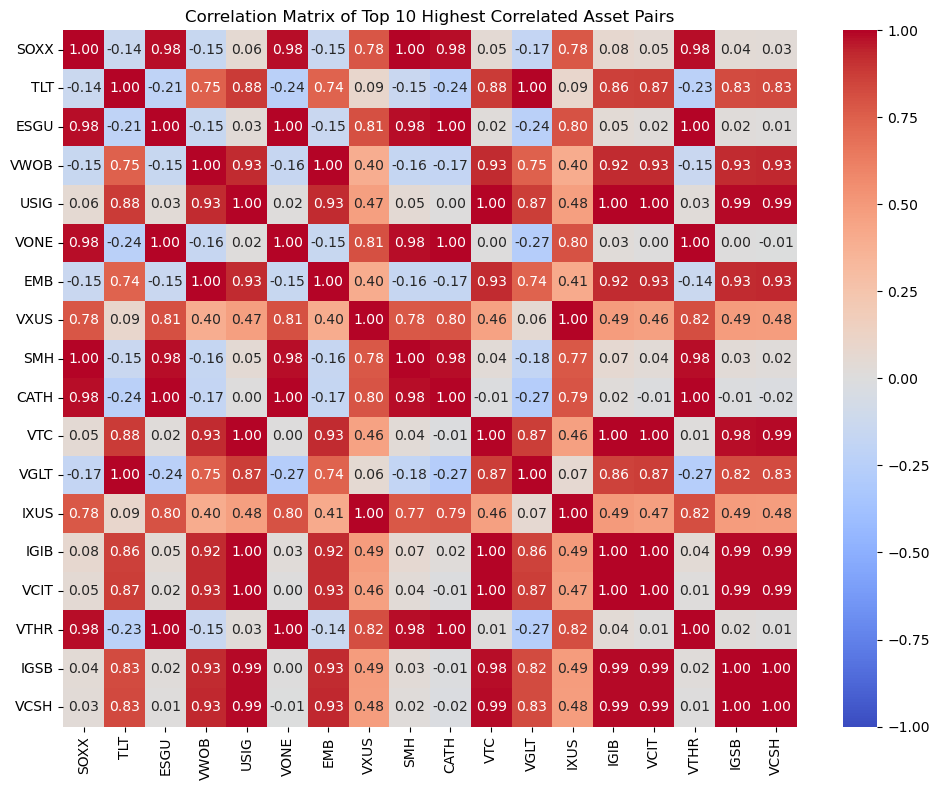

In [2]:
# Choose pairs based on correlation

correlation_matrix = df.corr()
correlation_pairs = correlation_matrix.unstack()
correlation_pairs = correlation_pairs[correlation_pairs != 1]
correlation_pairs_df = correlation_pairs.reset_index()
correlation_pairs_df.columns = ['Asset1', 'Asset2', 'Correlation']

correlation_pairs_df = correlation_pairs_df[correlation_pairs_df['Asset1'] < correlation_pairs_df['Asset2']]
sorted_correlation_pairs = correlation_pairs_df.sort_values(by='Correlation', ascending=False)
top_10_correlation_pairs = sorted_correlation_pairs.head(10)

# Create a new correlation matrix with only the top 10 pairs
top_10_assets = list(set(top_10_correlation_pairs['Asset1'].tolist() + top_10_correlation_pairs['Asset2'].tolist()))
top_10_correlation_matrix = correlation_matrix.loc[top_10_assets, top_10_assets]

# Visualize the correlation matrix for top 10 pairs
plt.figure(figsize=(10, 8))
sns.heatmap(top_10_correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix of Top 10 Highest Correlated Asset Pairs')
plt.tight_layout()
plt.savefig('top_10_correlation_matrix_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

correlation_pairs_df = correlation_pairs_df[correlation_pairs_df['Asset1'] < correlation_pairs_df['Asset2']]
sorted_correlation_pairs = correlation_pairs_df.sort_values(by='Correlation', ascending=False)
top_19_correlation_pairs = sorted_correlation_pairs.head(19)
top_19_pairs_list = top_19_correlation_pairs[['Asset1', 'Asset2']].values.tolist()

In [3]:
# Compute spread stats

spread_stats = {}

for pair in top_19_pairs_list:
    ticker_1 = pair[0]
    ticker_2 = pair[1]

    ticker_series_1 = df[ticker_1]
    ticker_series_2 = df[ticker_2]

    slope, intercept, _, _, _ = linregress(ticker_series_1, ticker_series_2)
    spread = ticker_series_2 - (slope * ticker_series_1 + intercept)

    spread_mean = np.mean(spread.values)
    spread_std = np.std(spread.values)

    spread_stats[f"{ticker_1}_{ticker_2}"] = {
        "slope": slope,
        "intercept": intercept,
        "mean": spread_mean,
        "std": spread_std
    }


/var/folders/q9/kw9849fs50s9d34q6y66ny200000gn/T/ipykernel_2653/2014761106.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if positions[i] != positions[i-1]:
/var/folders/q9/kw9849fs50s9d34q6y66ny200000gn/T/ipykernel_2653/2014761106.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if positions[i] == 1:
/var/folders/q9/kw9849fs50s9d34q6y66ny200000gn/T/ipykernel_2653/2014761106.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

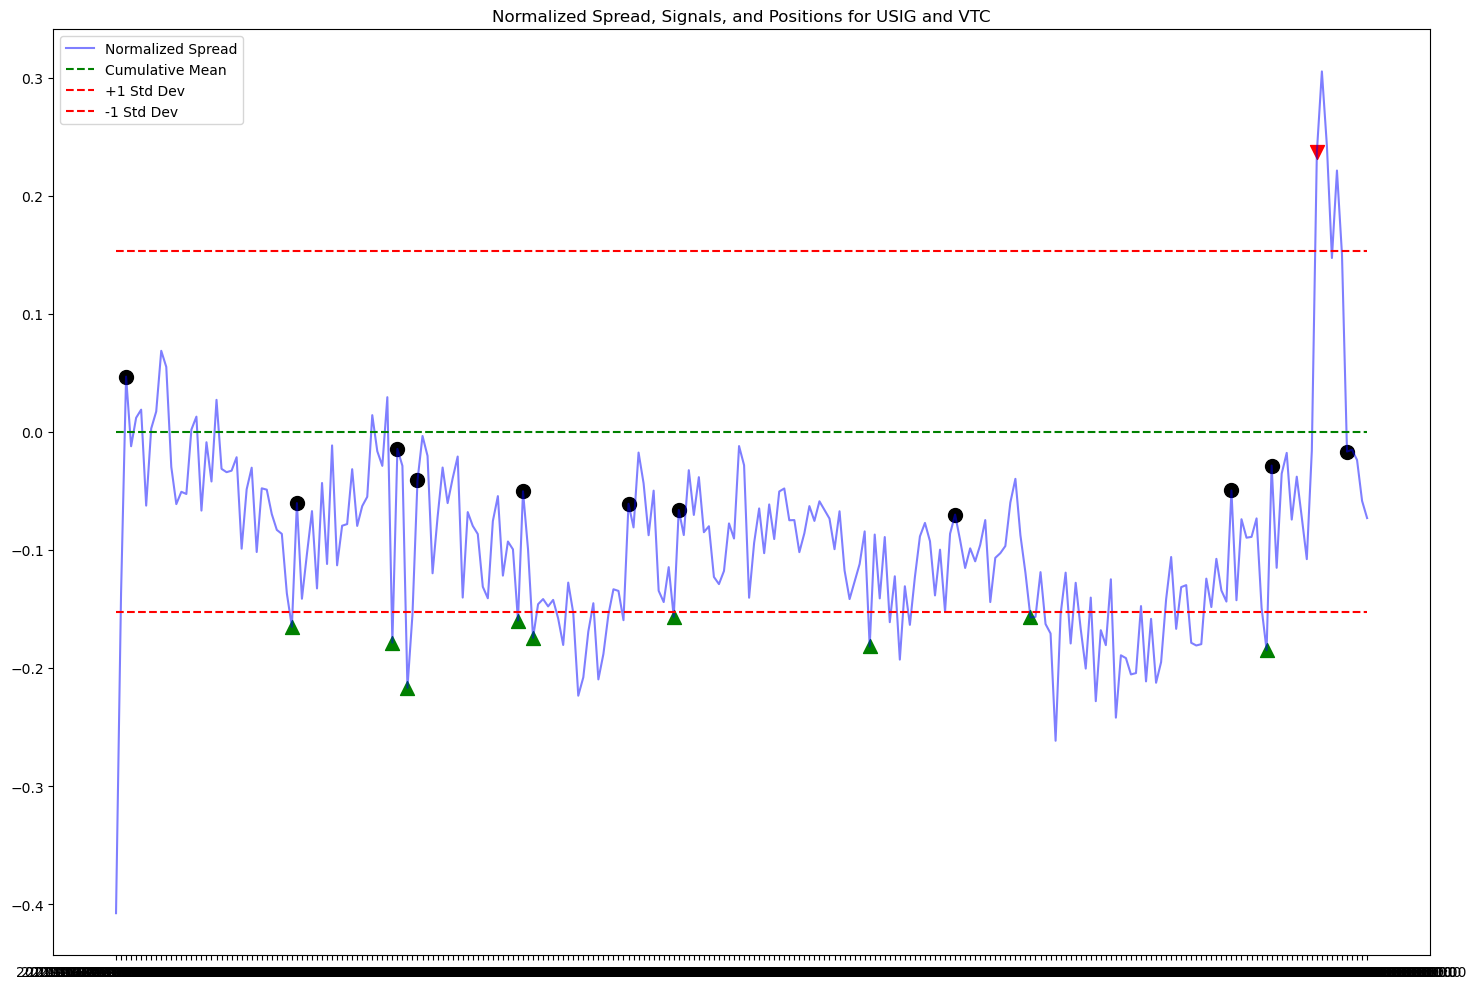

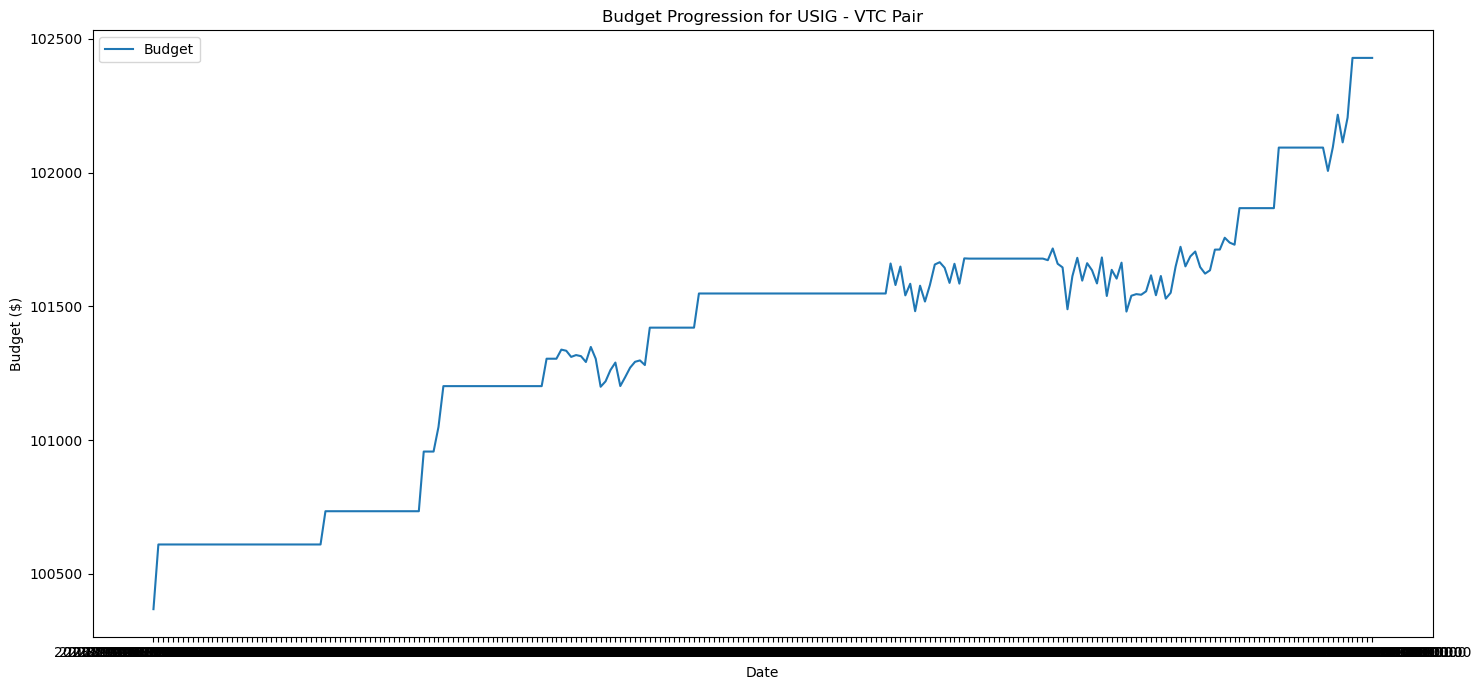

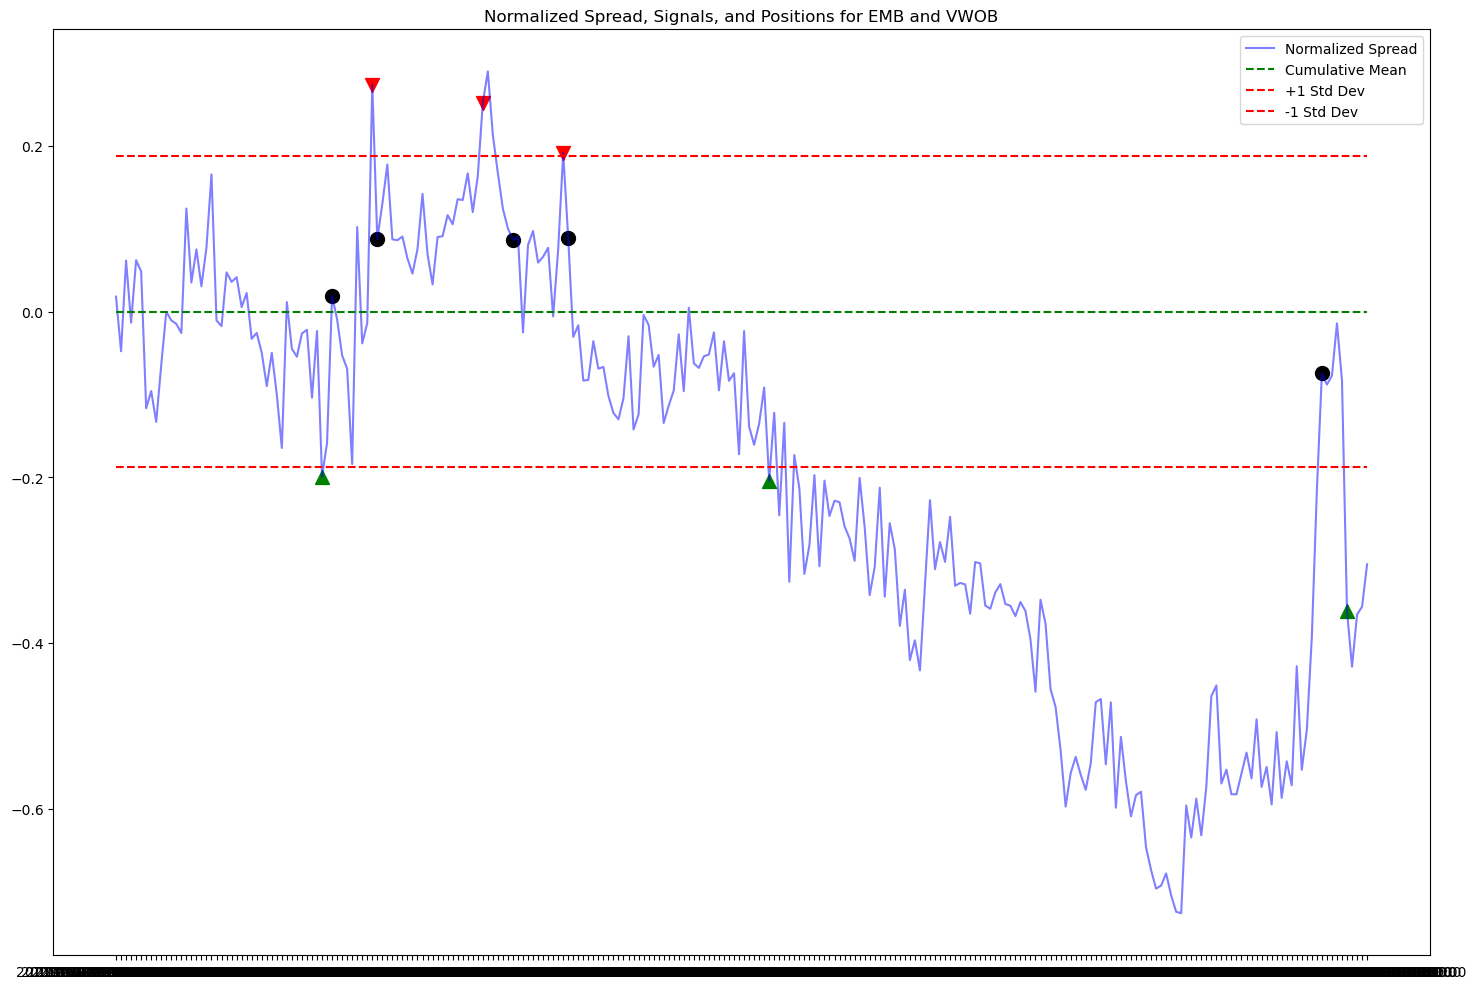

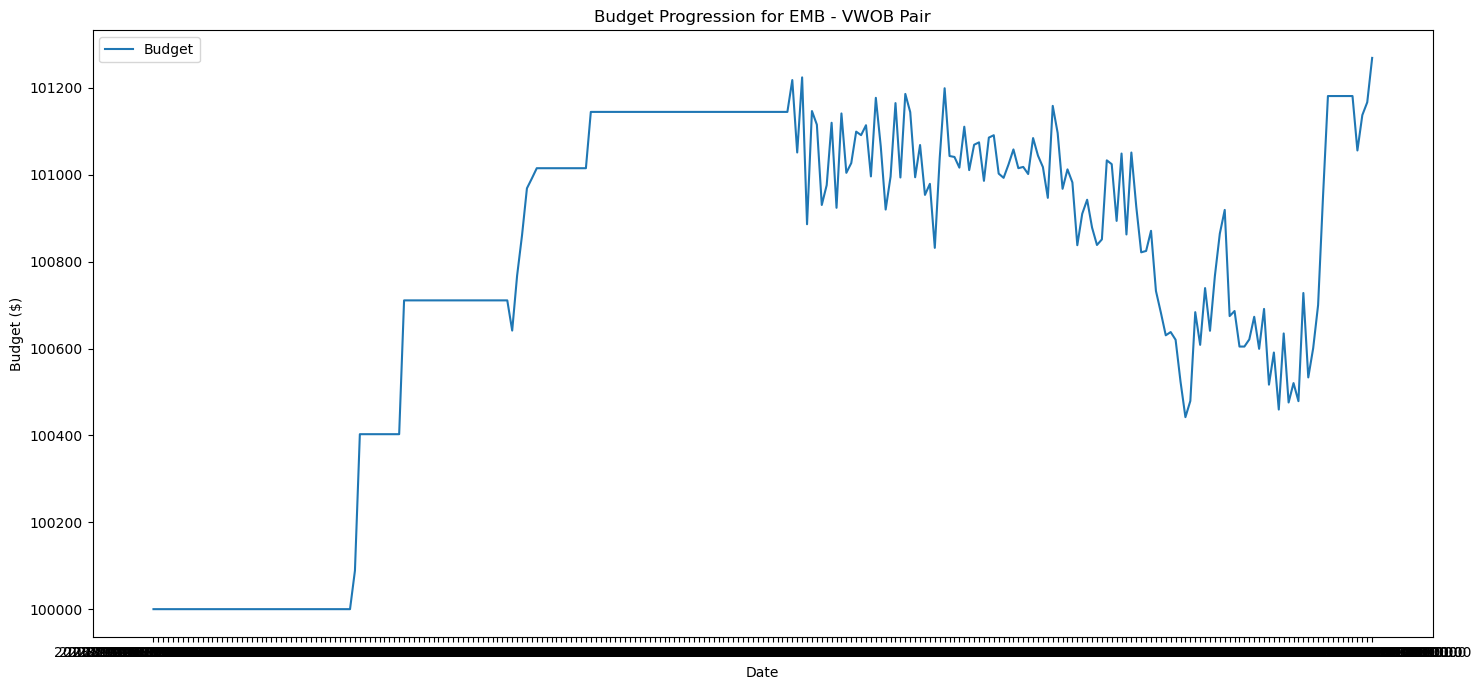

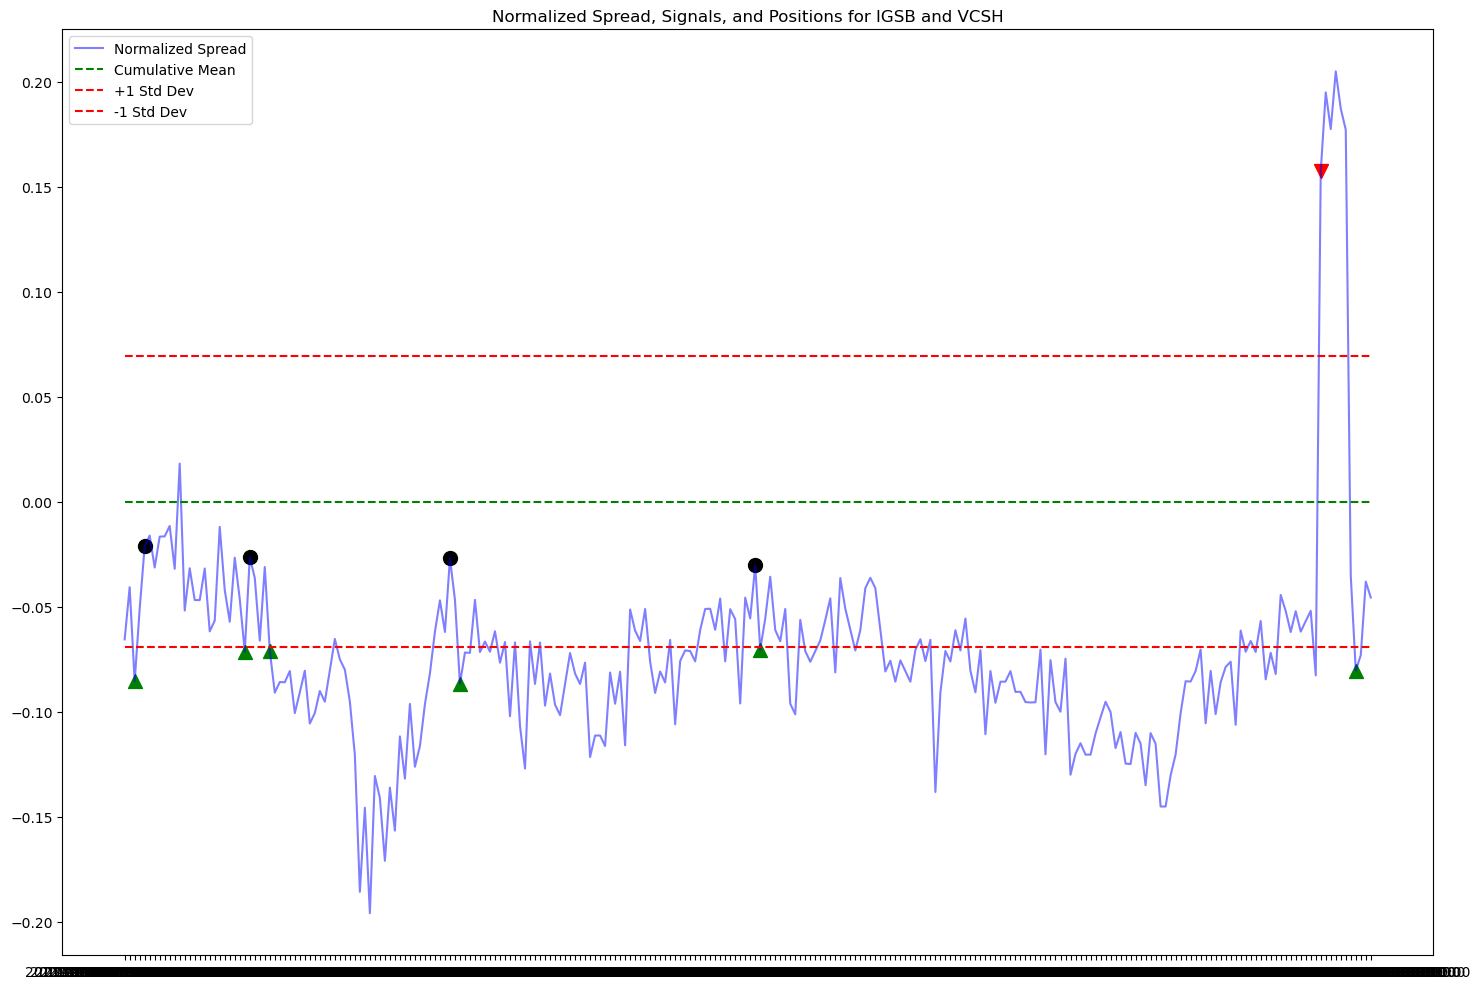

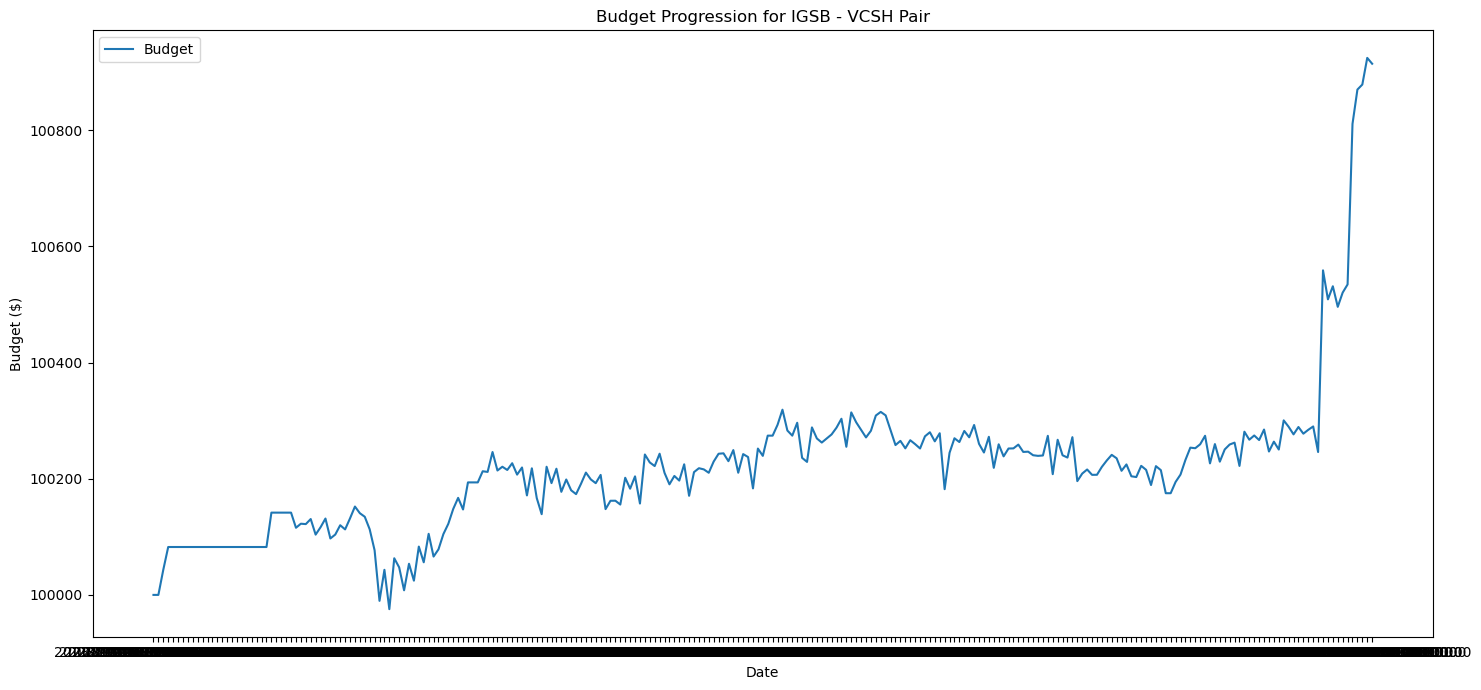

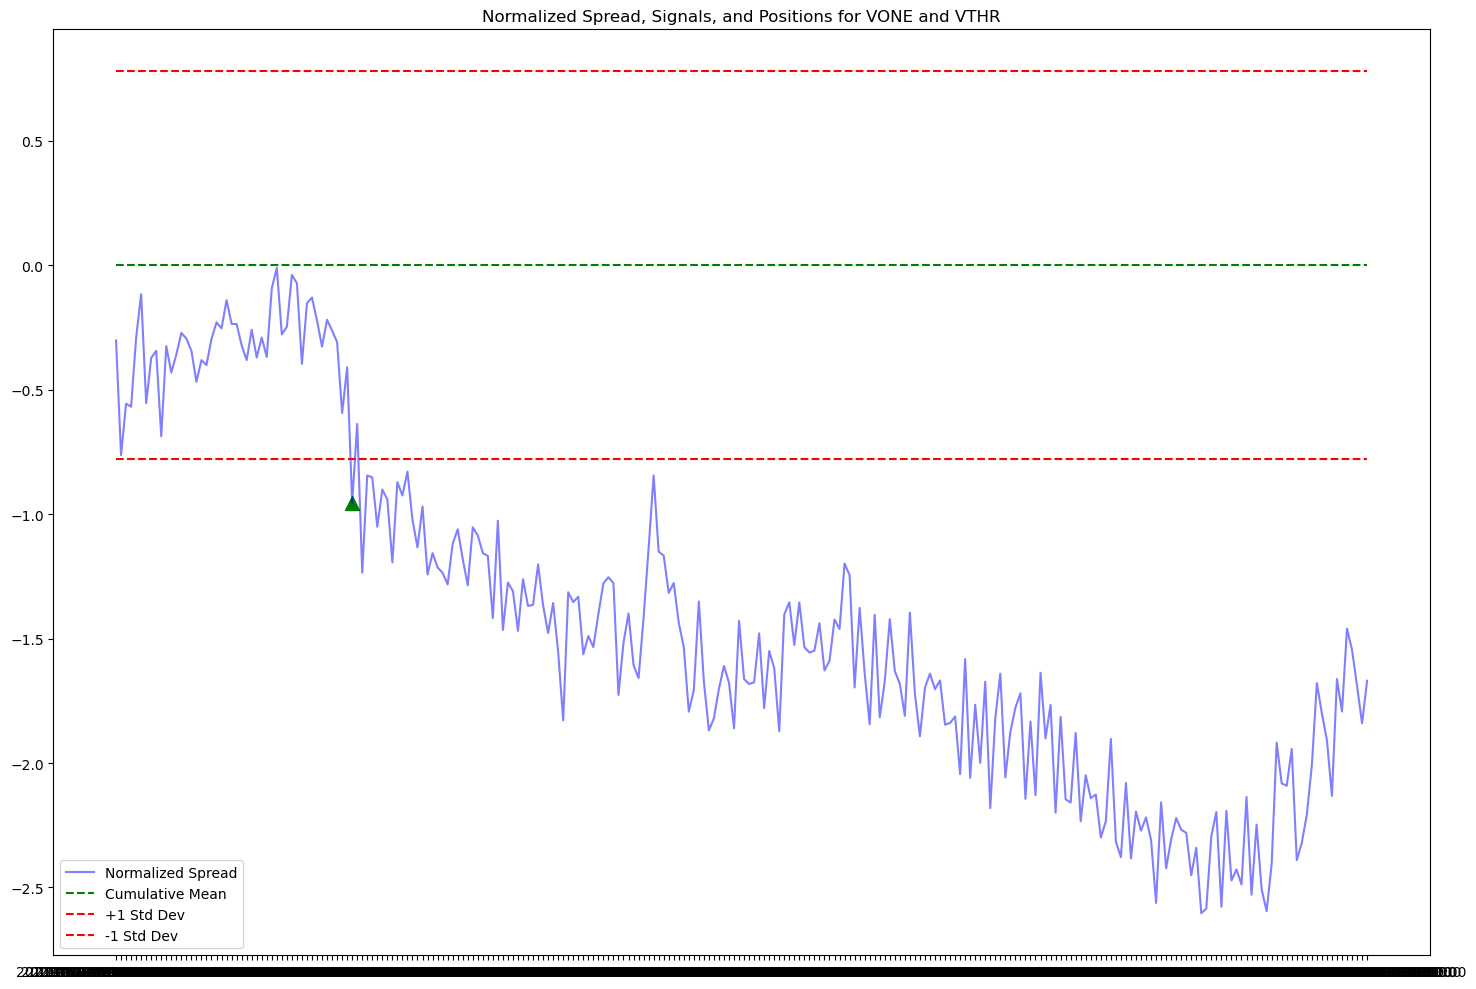

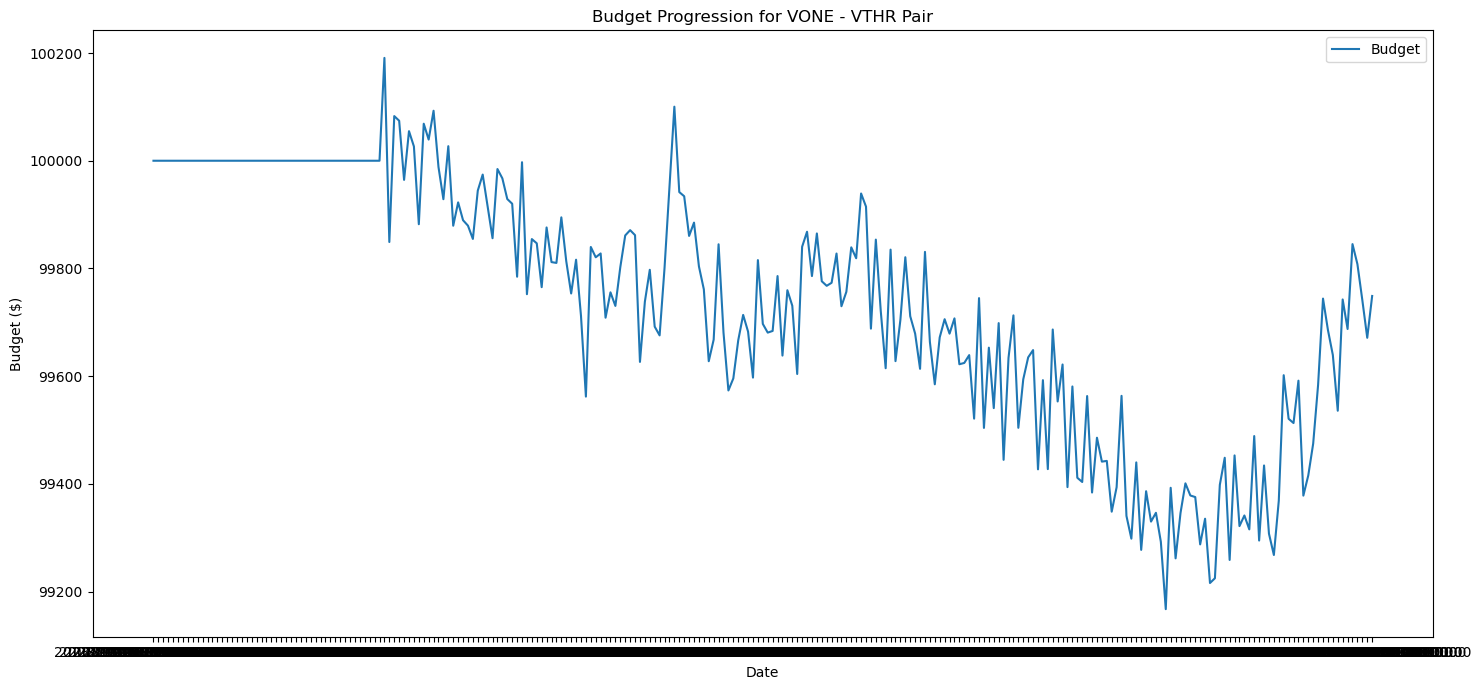

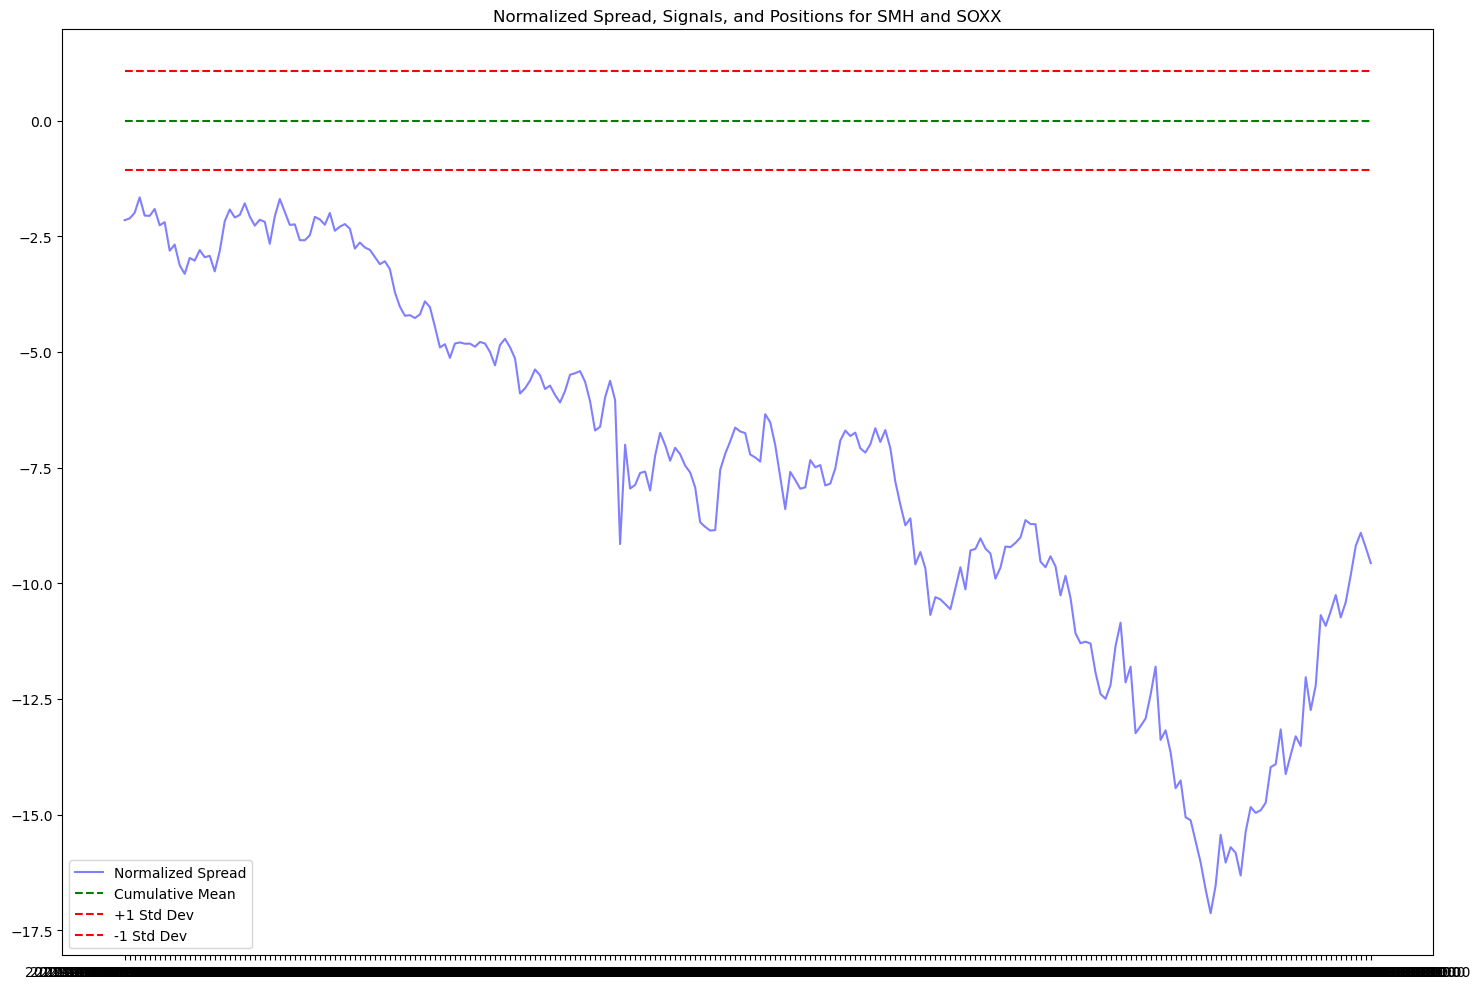

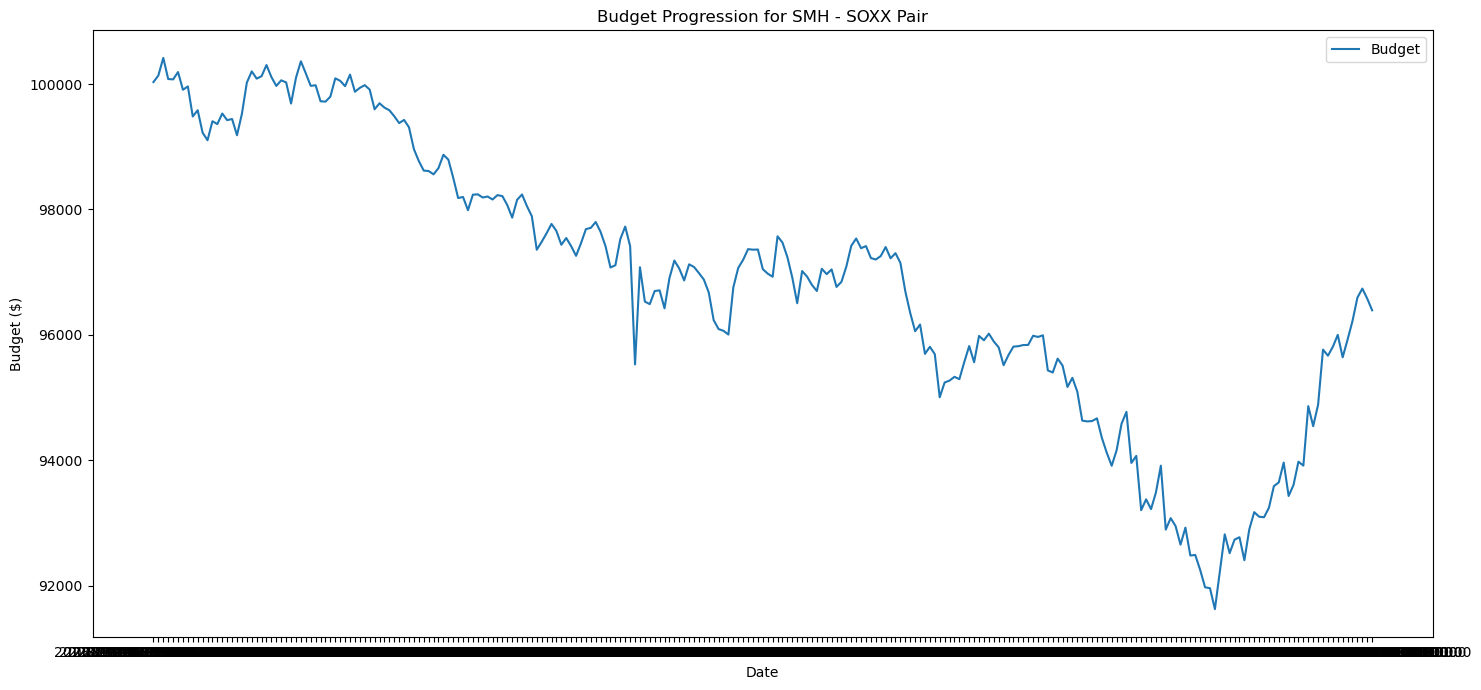

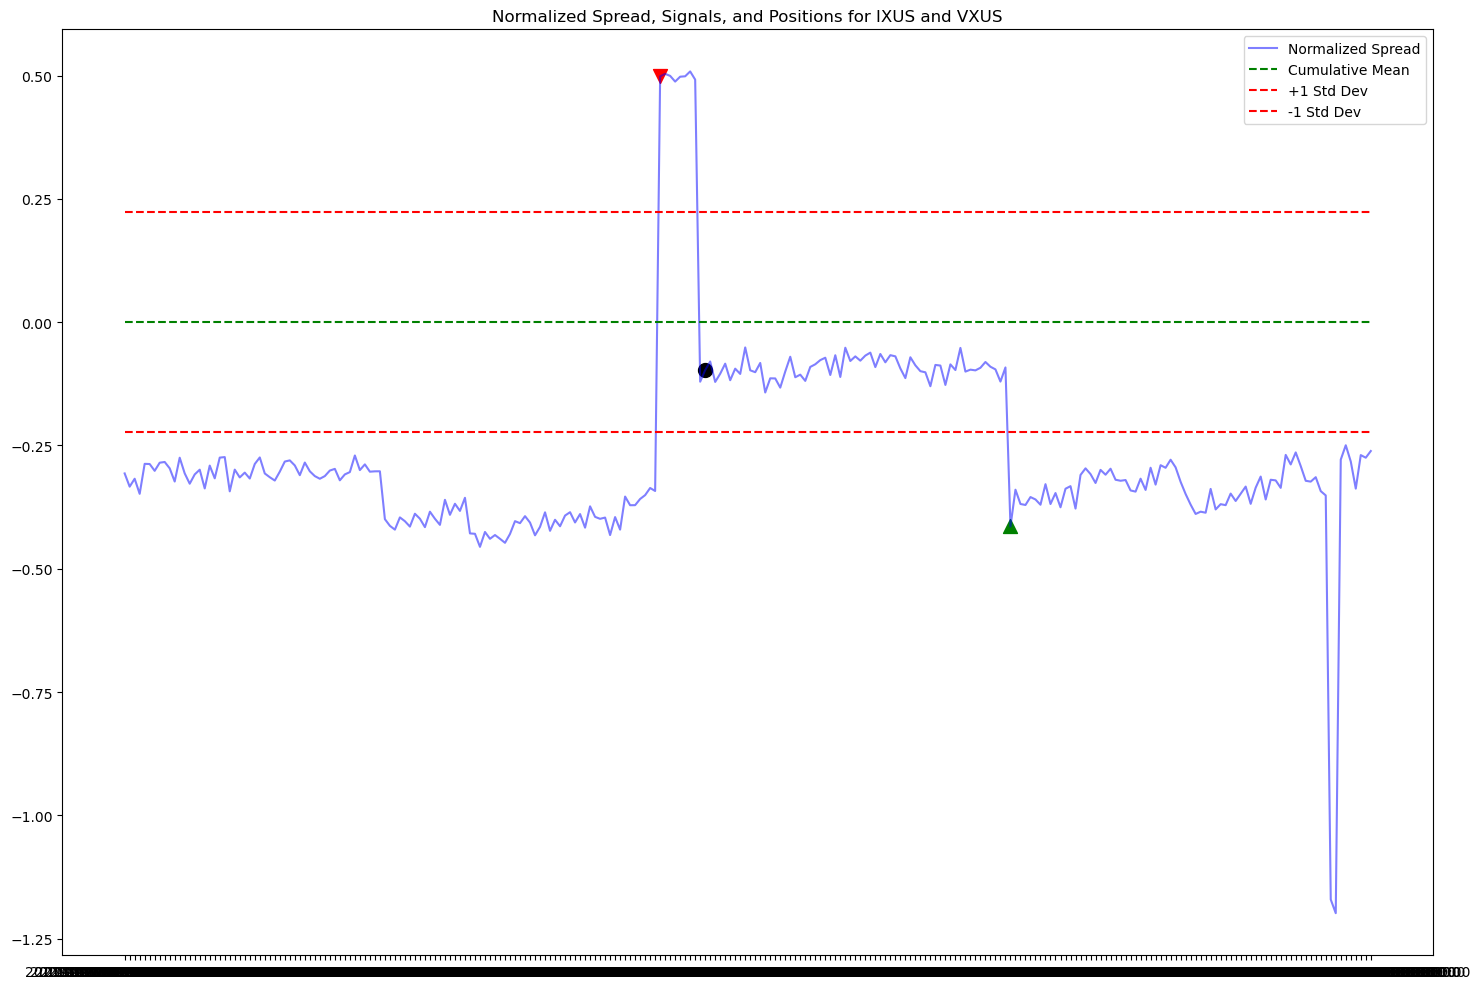

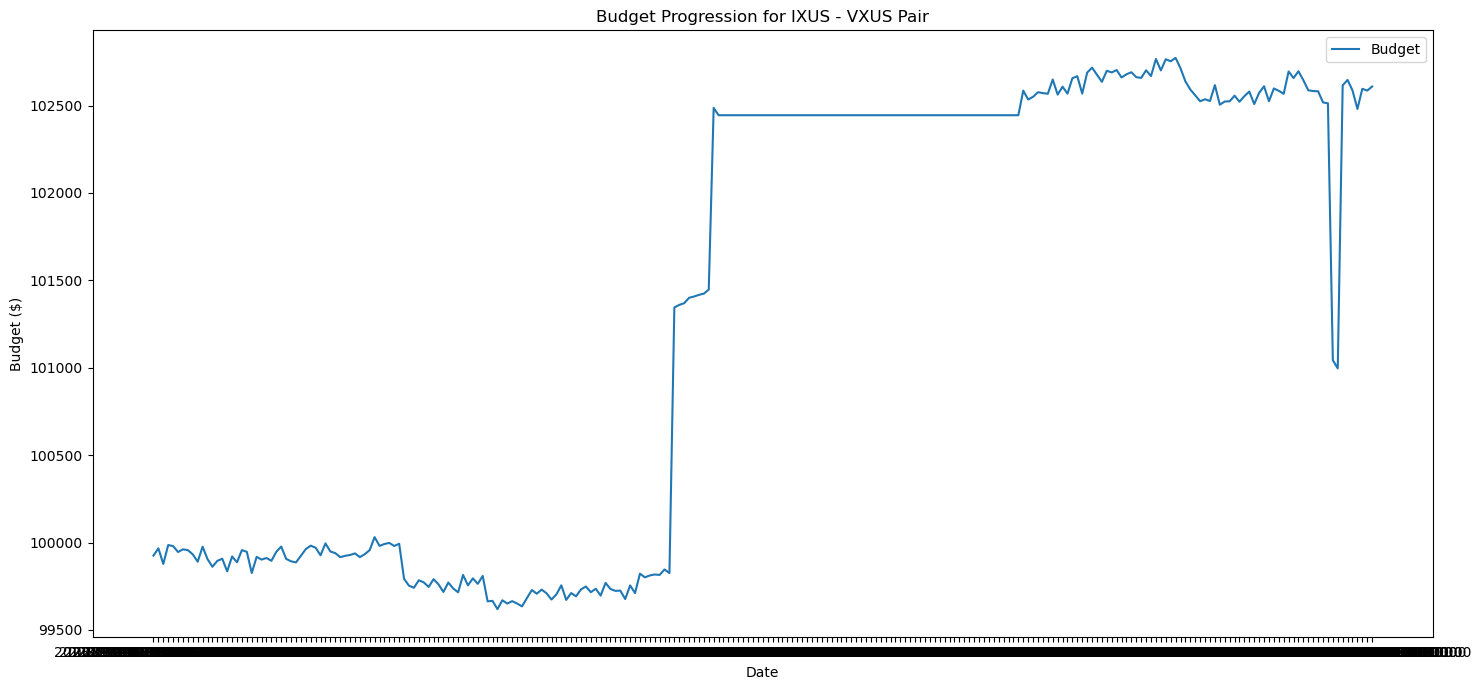

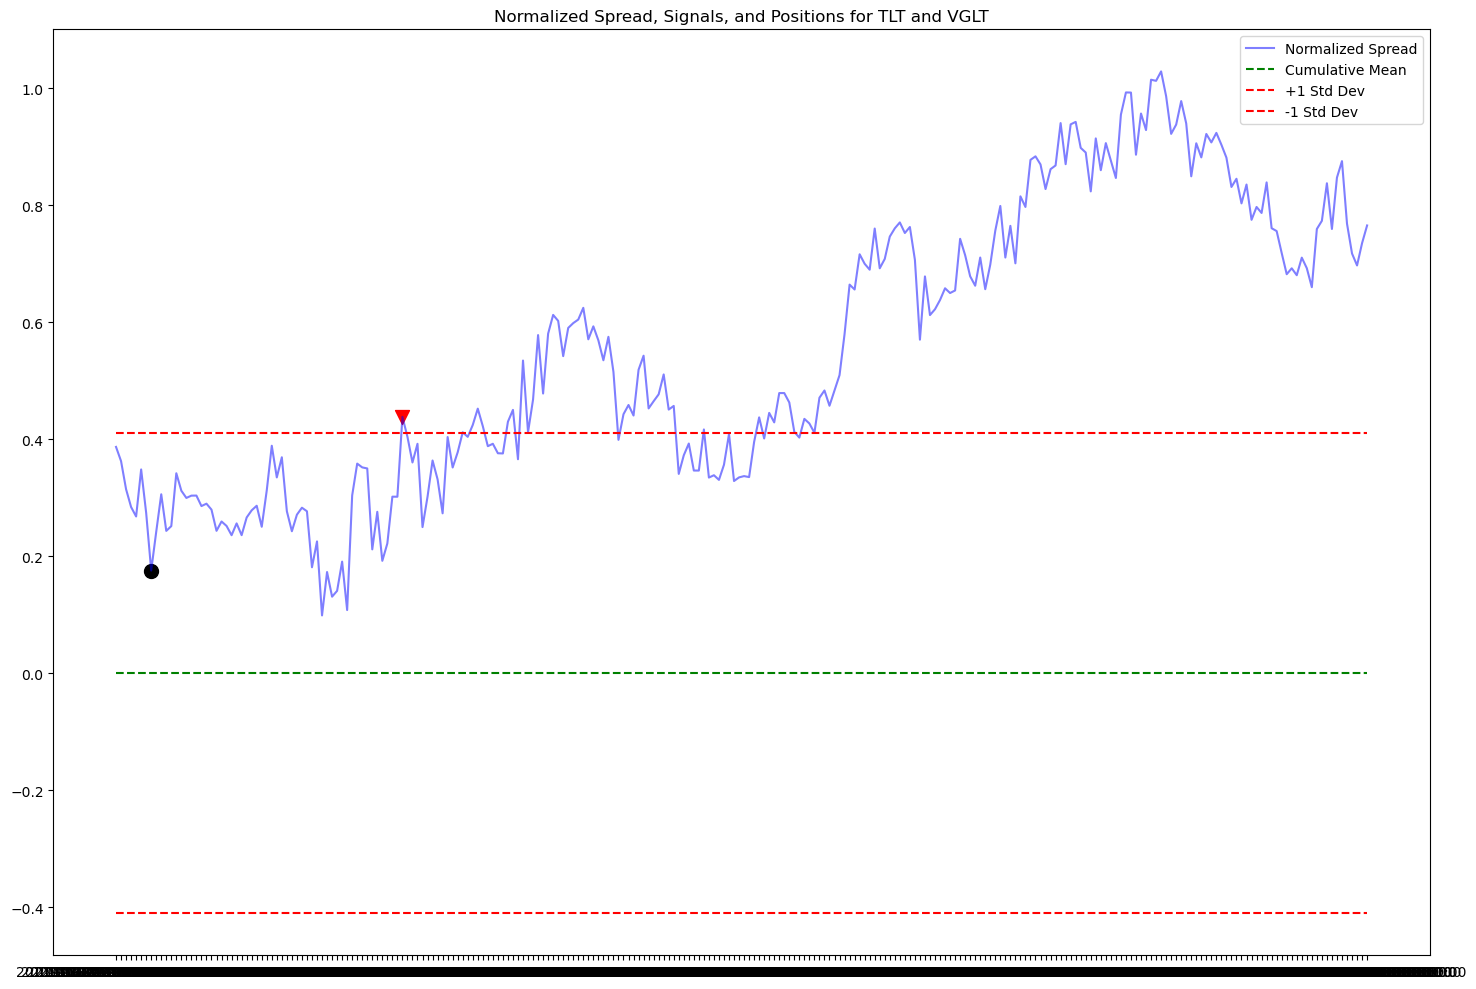

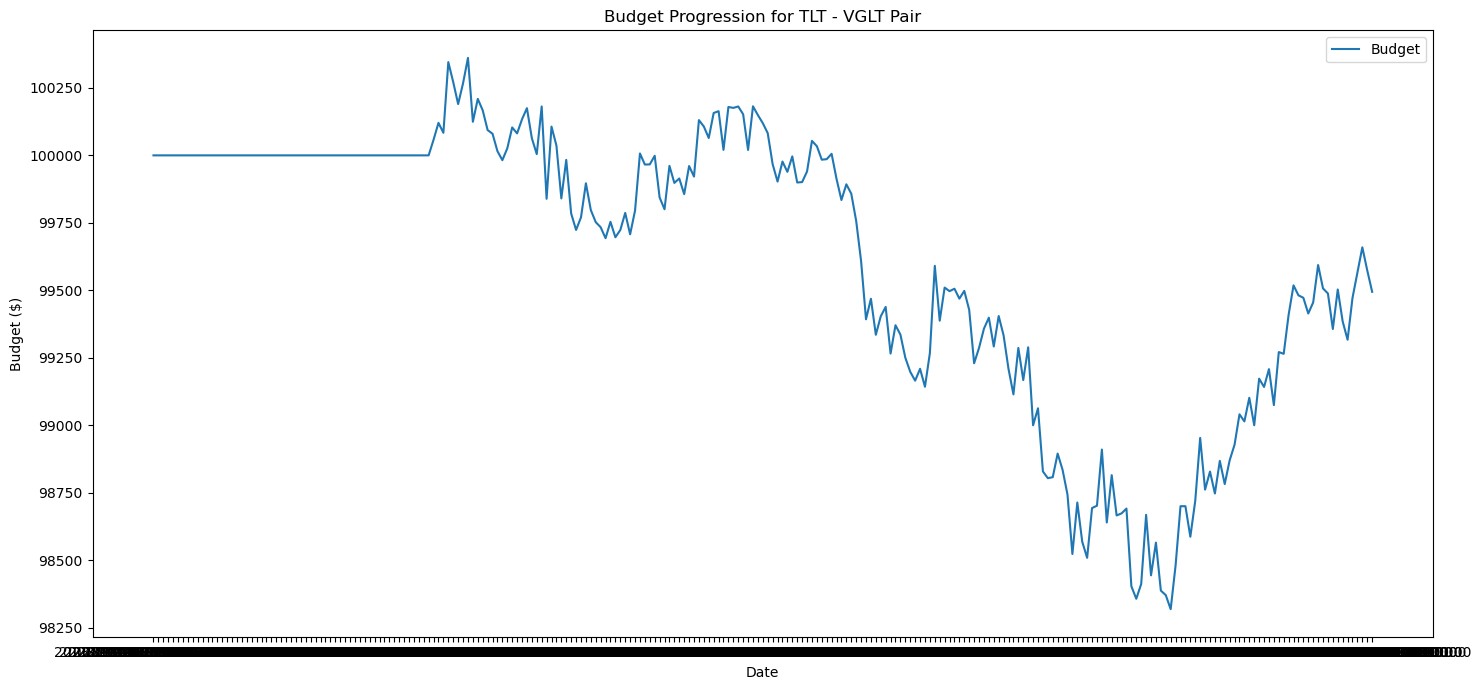

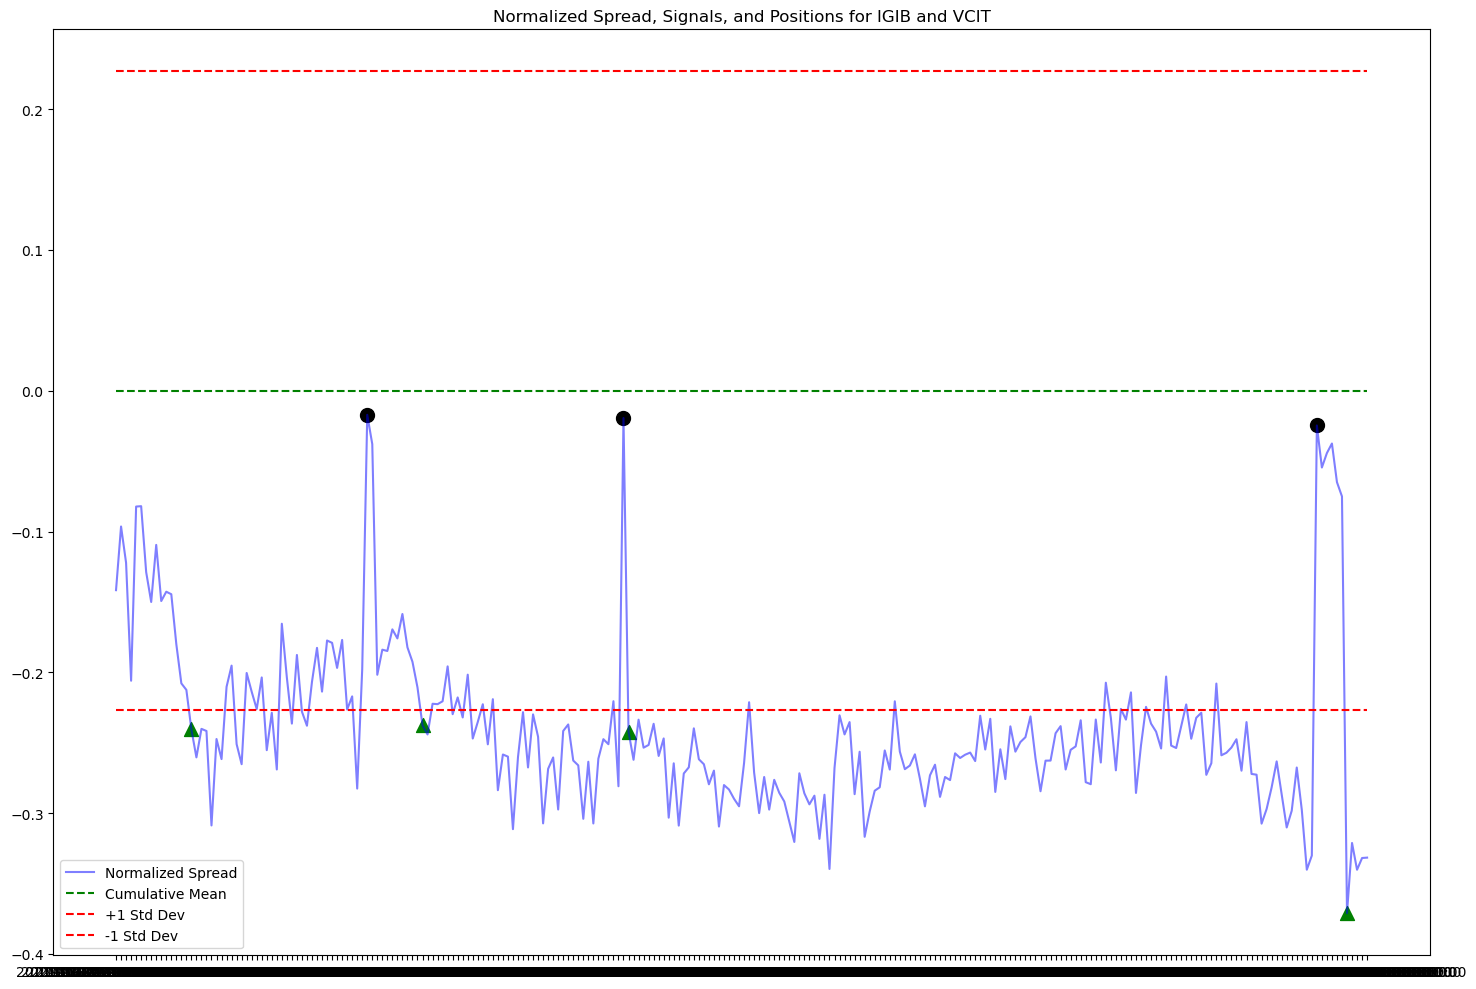

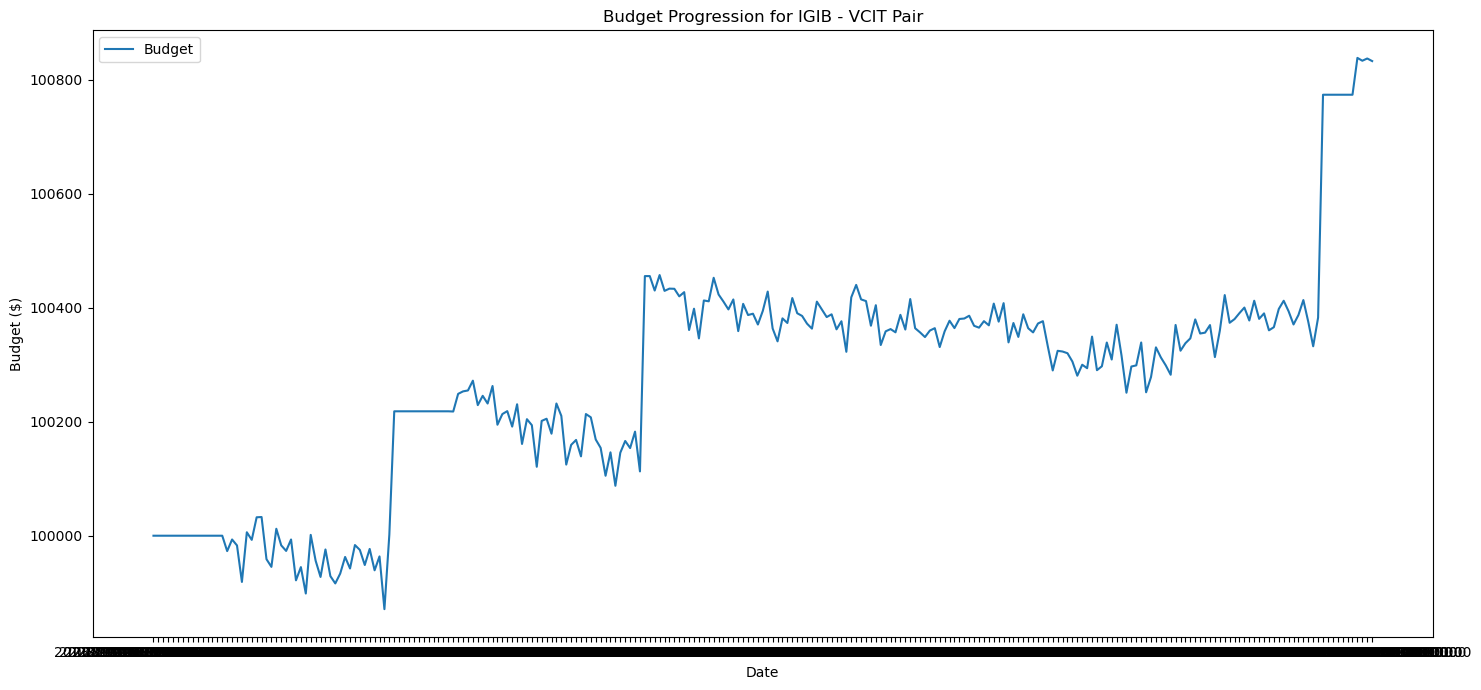

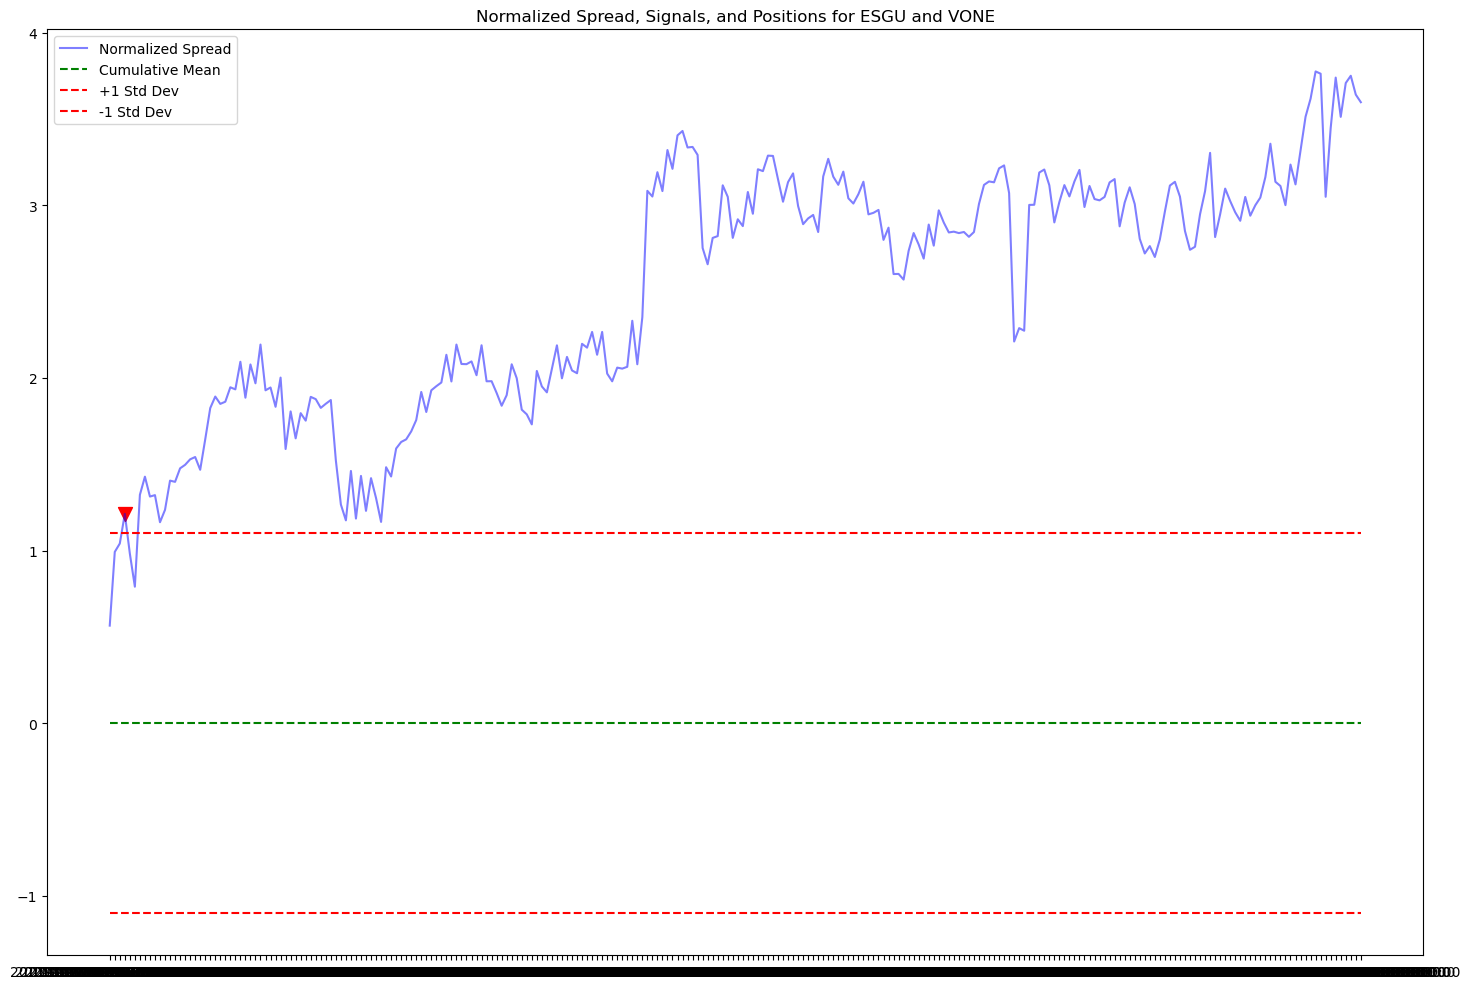

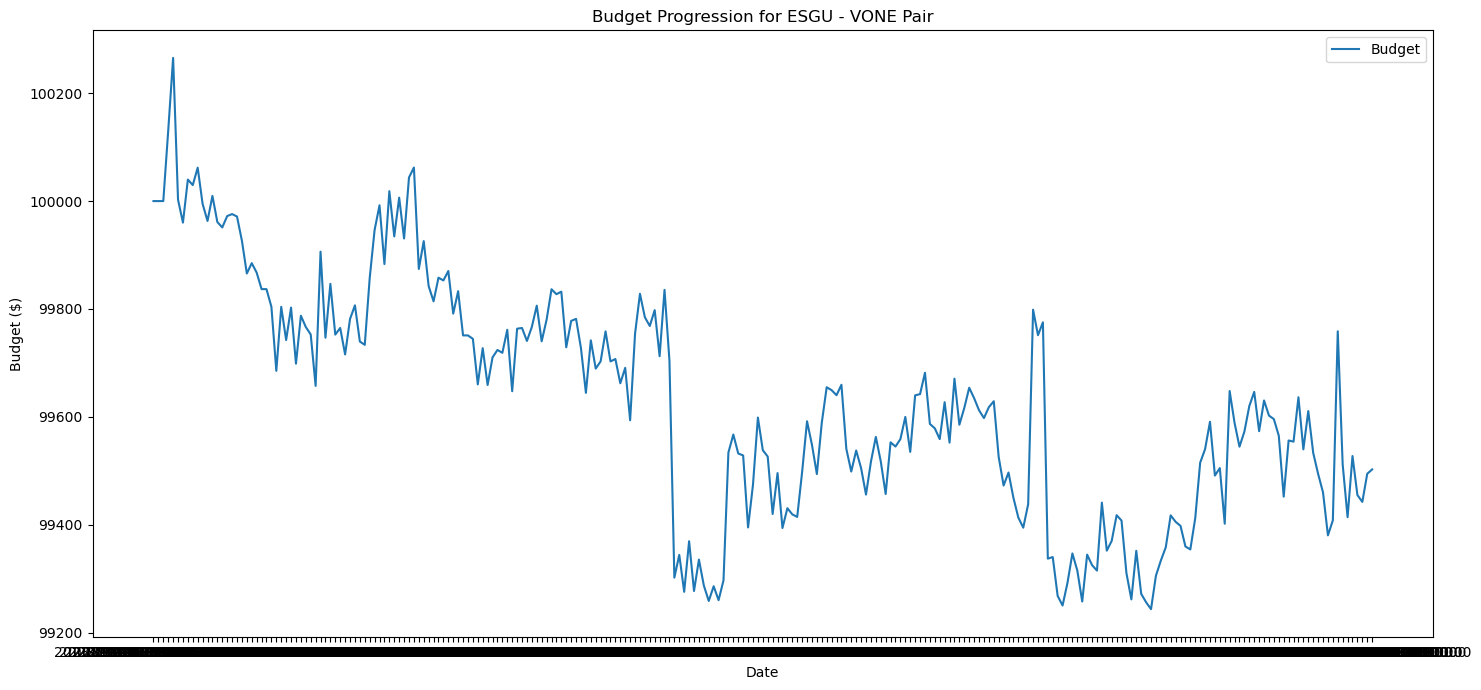

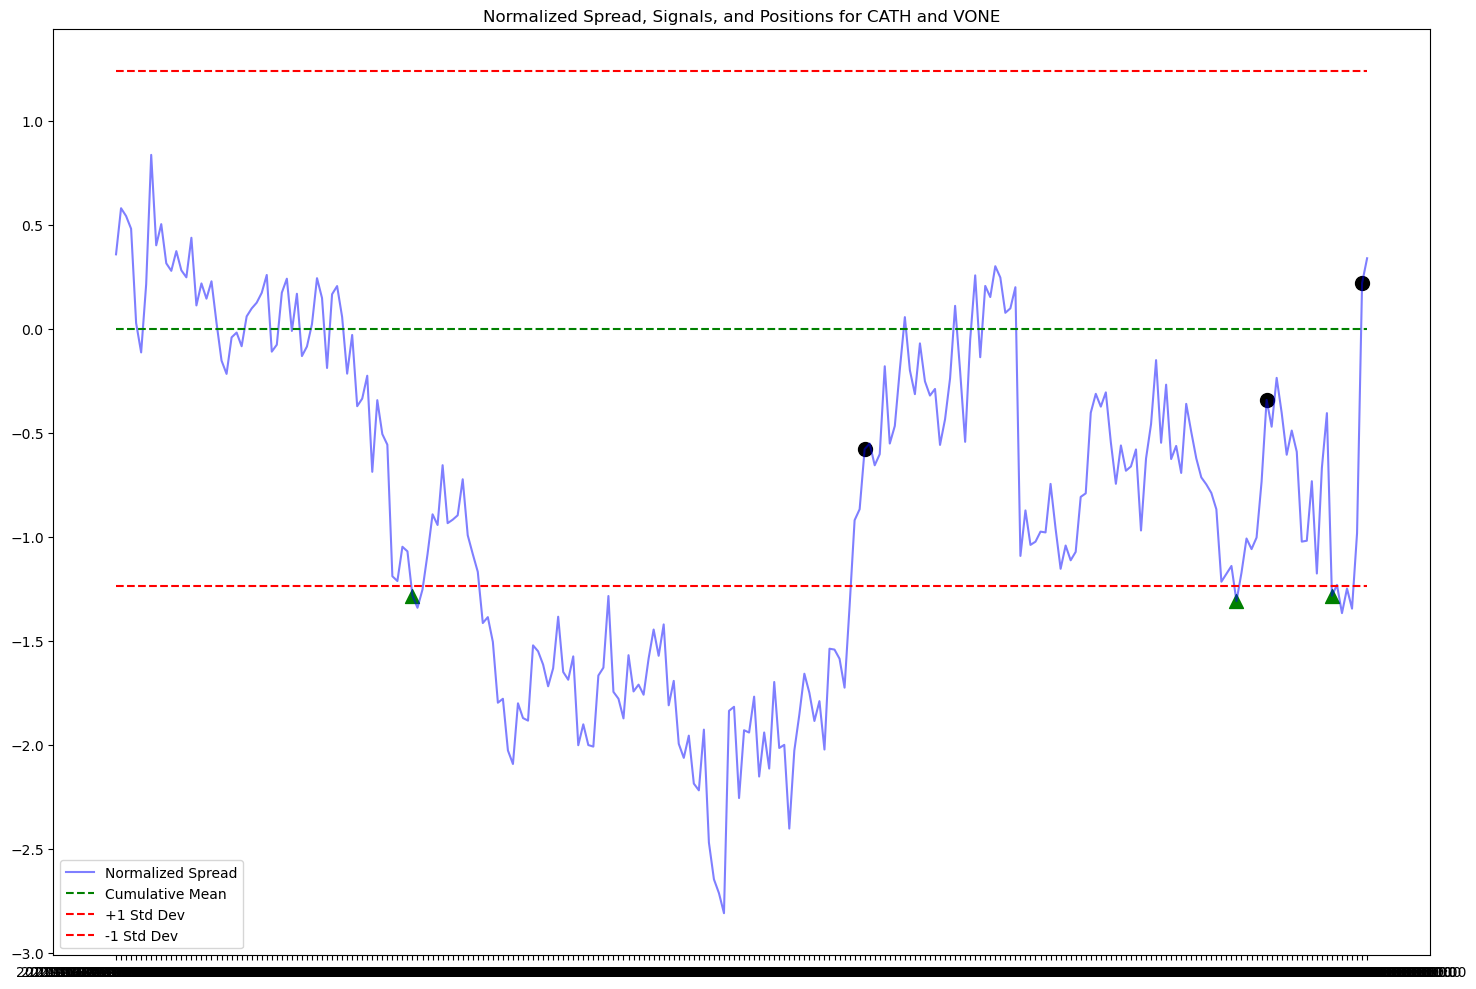

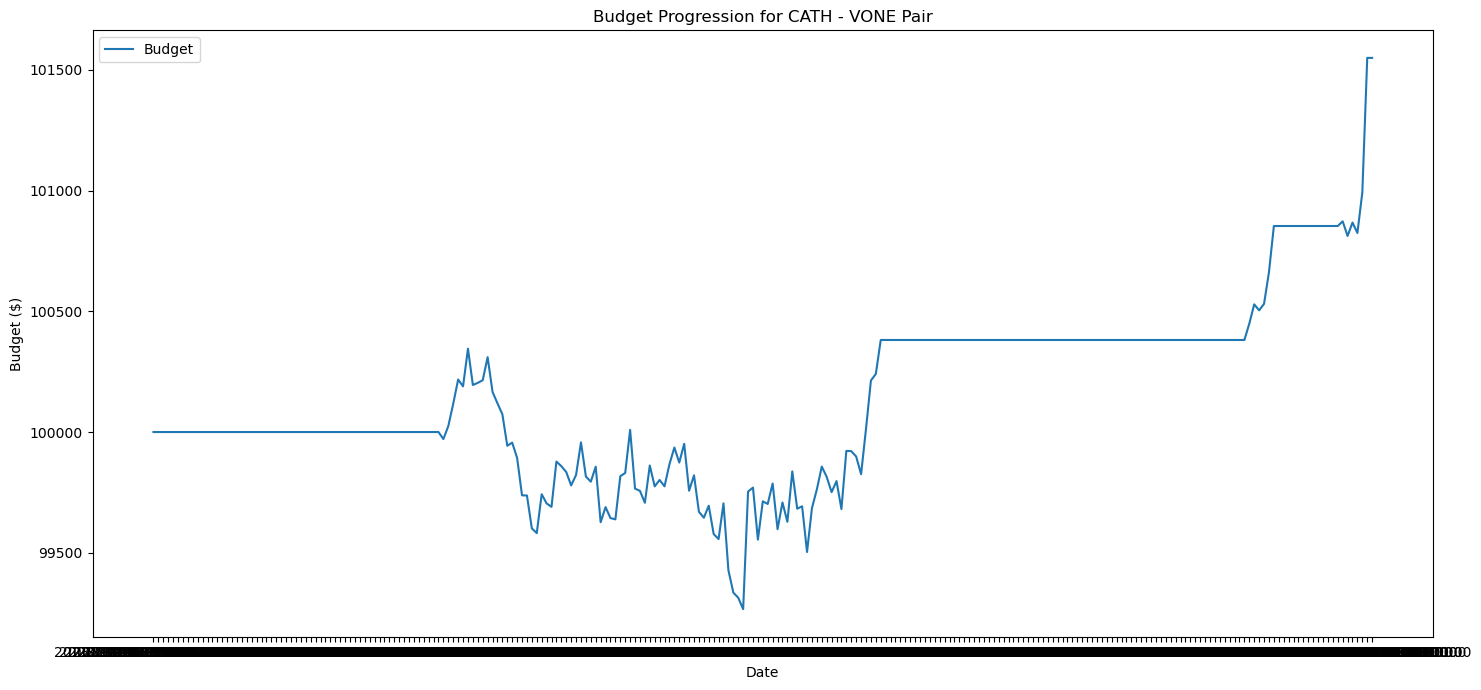

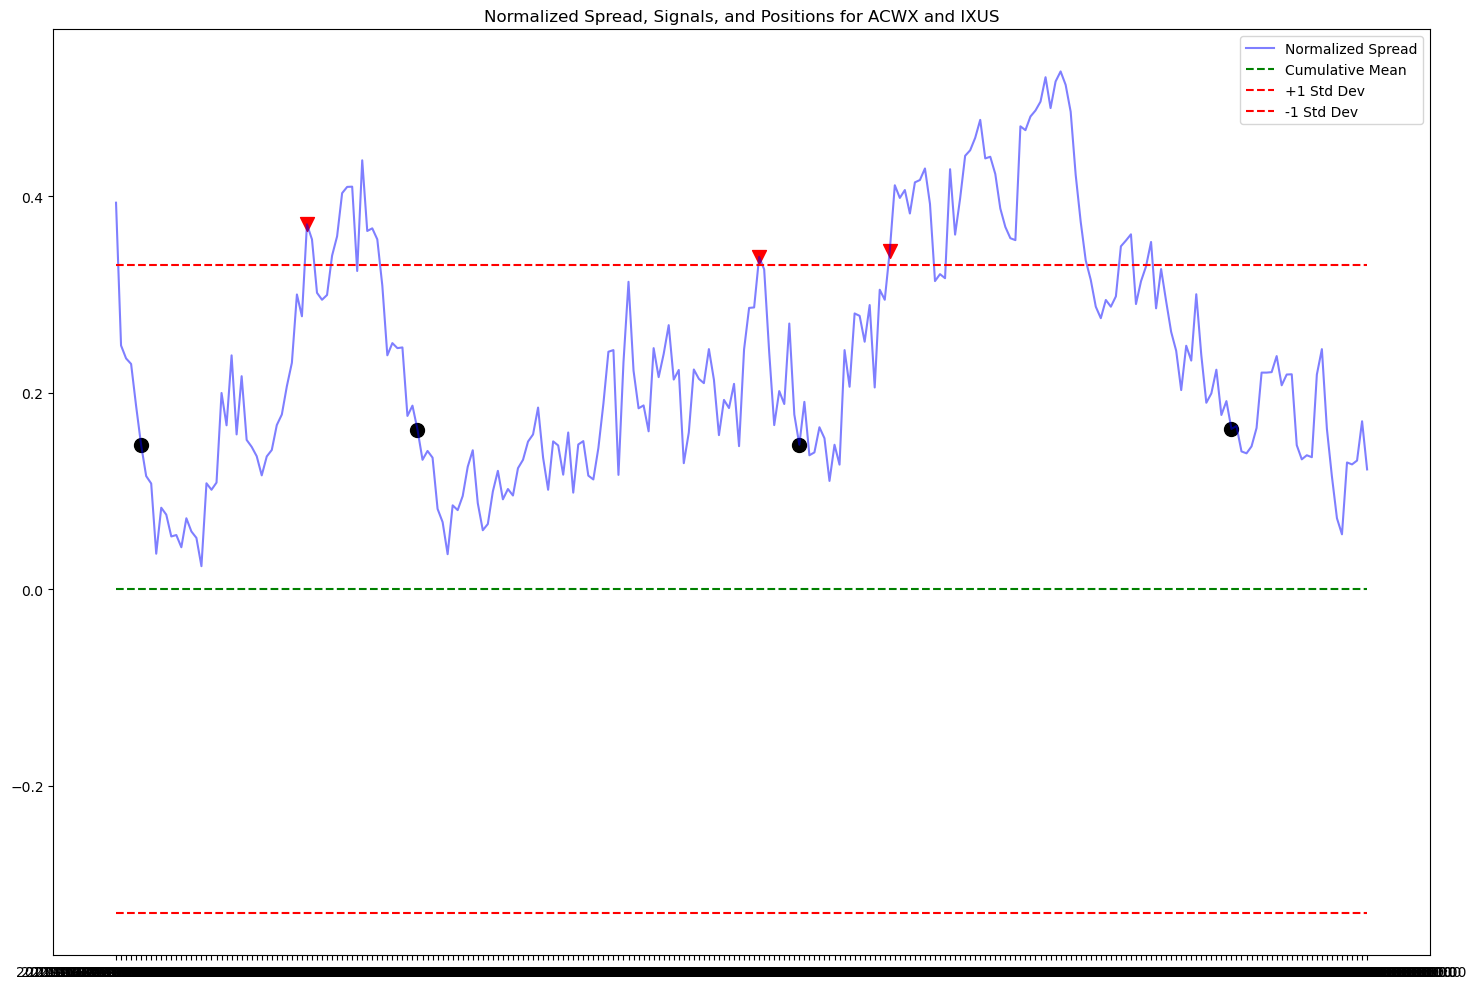

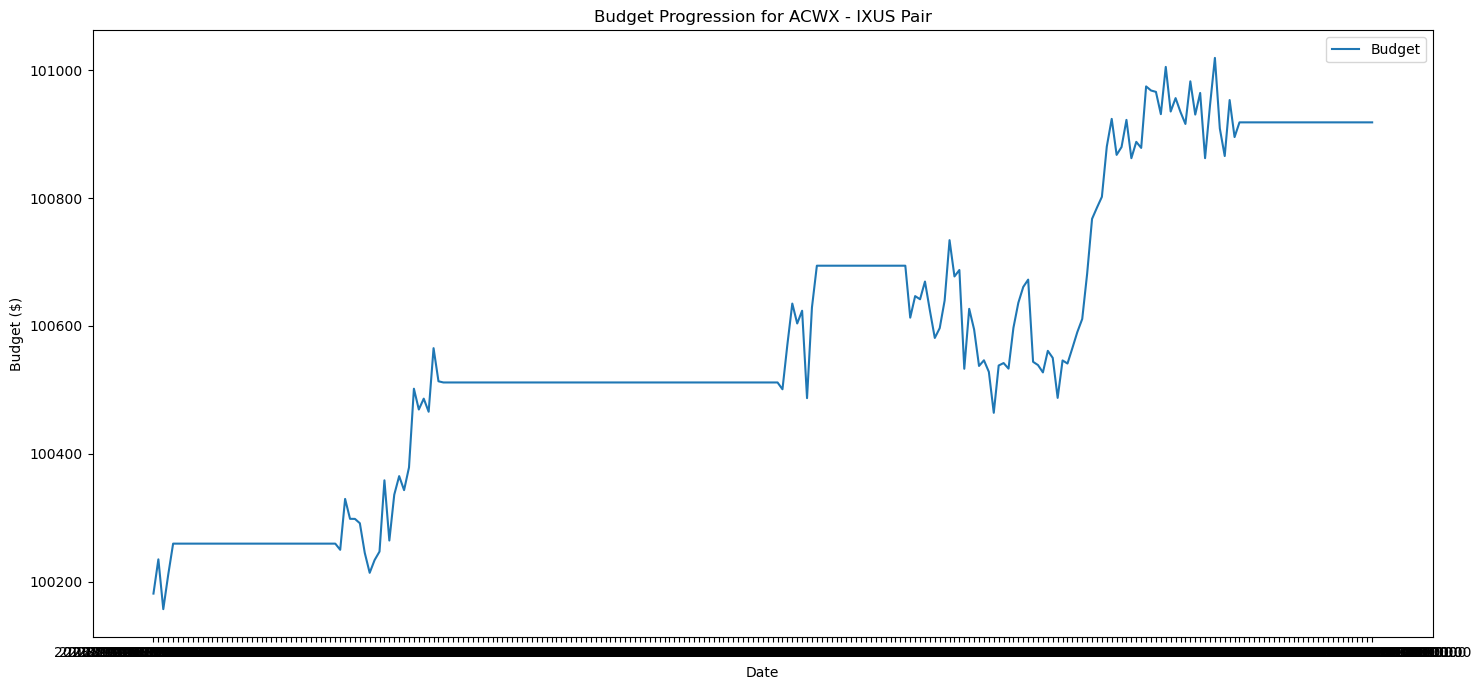

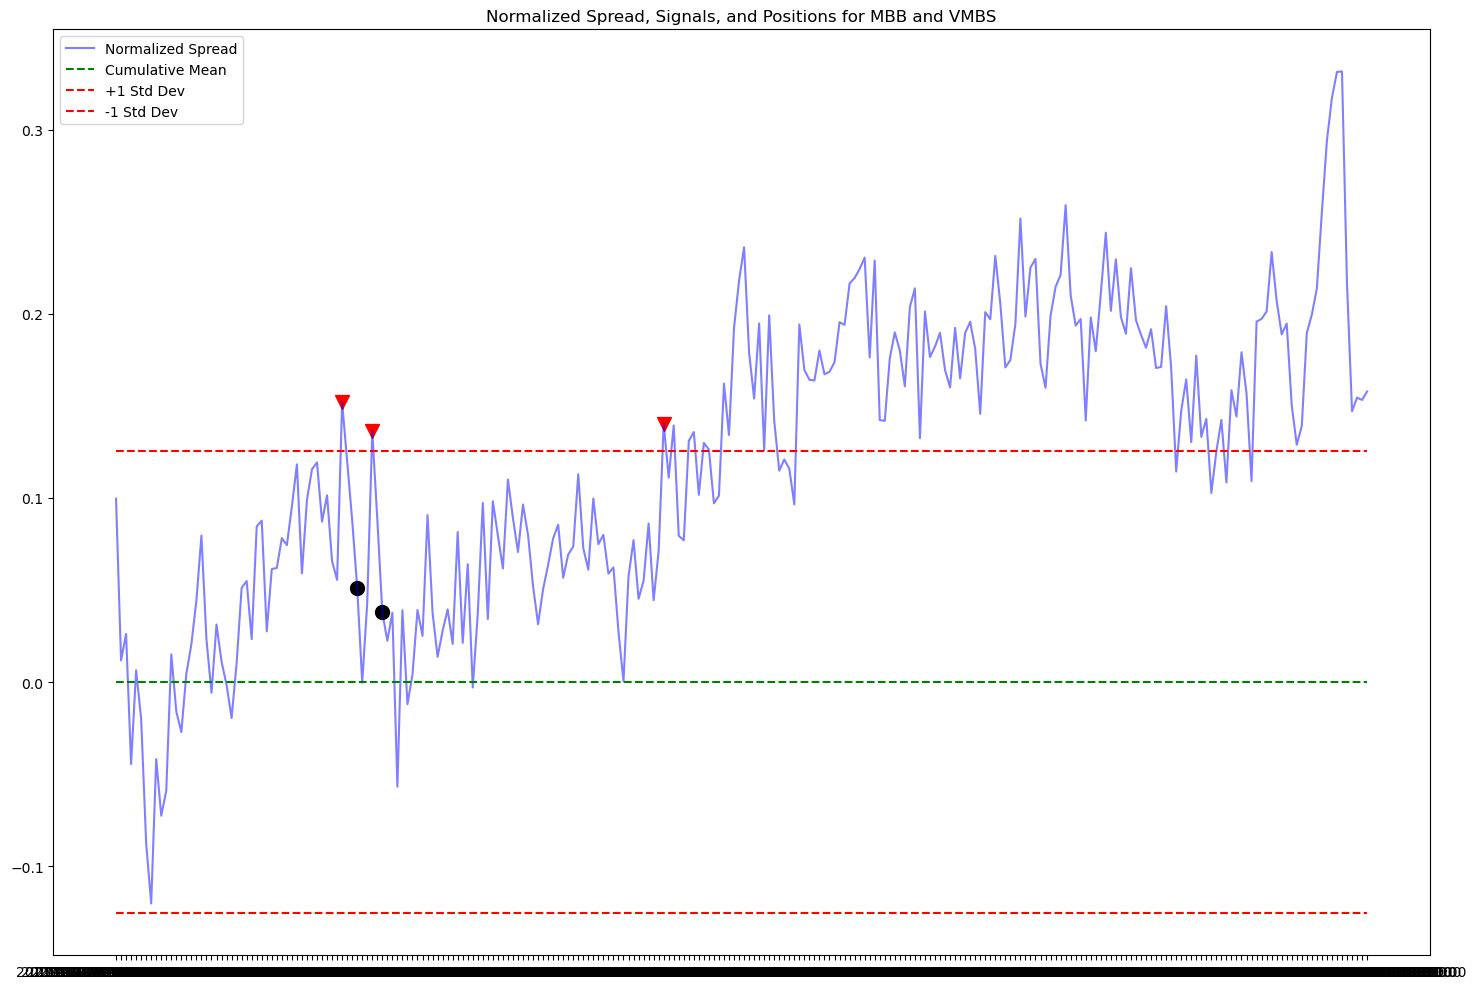

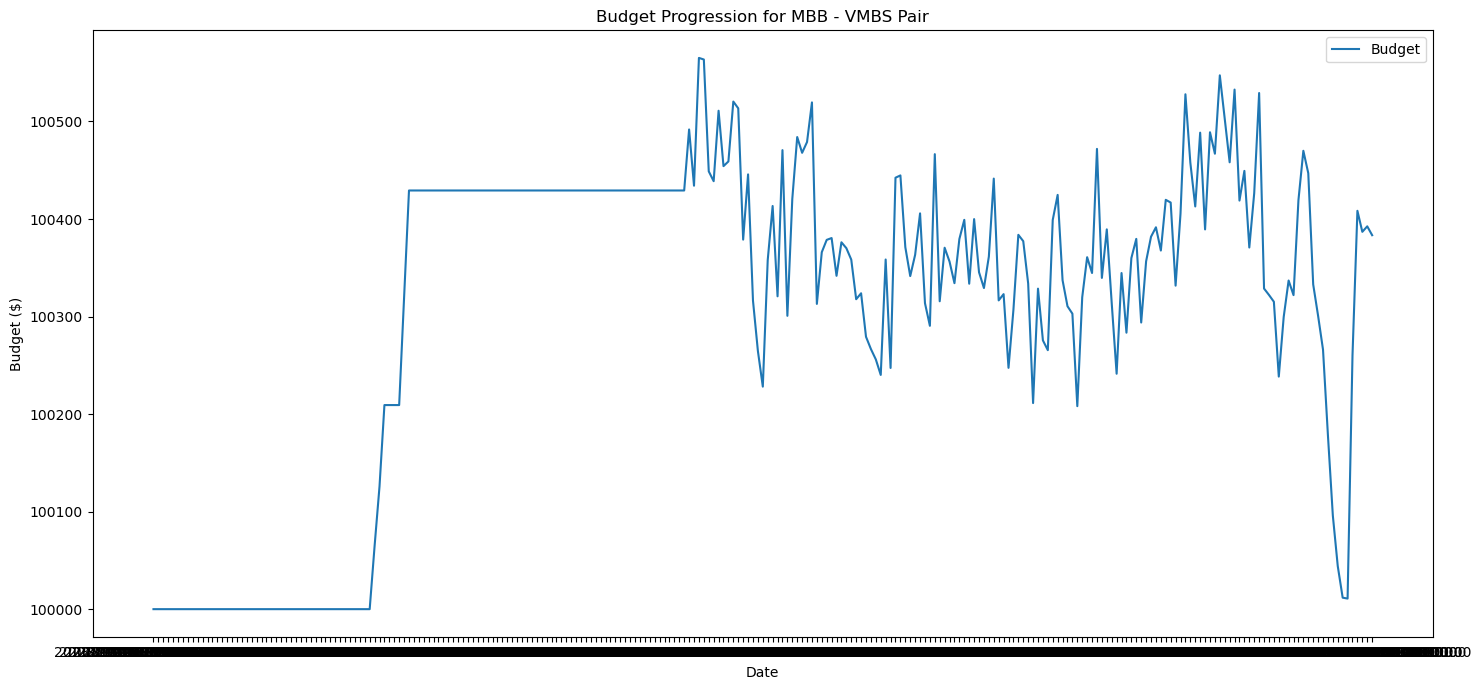

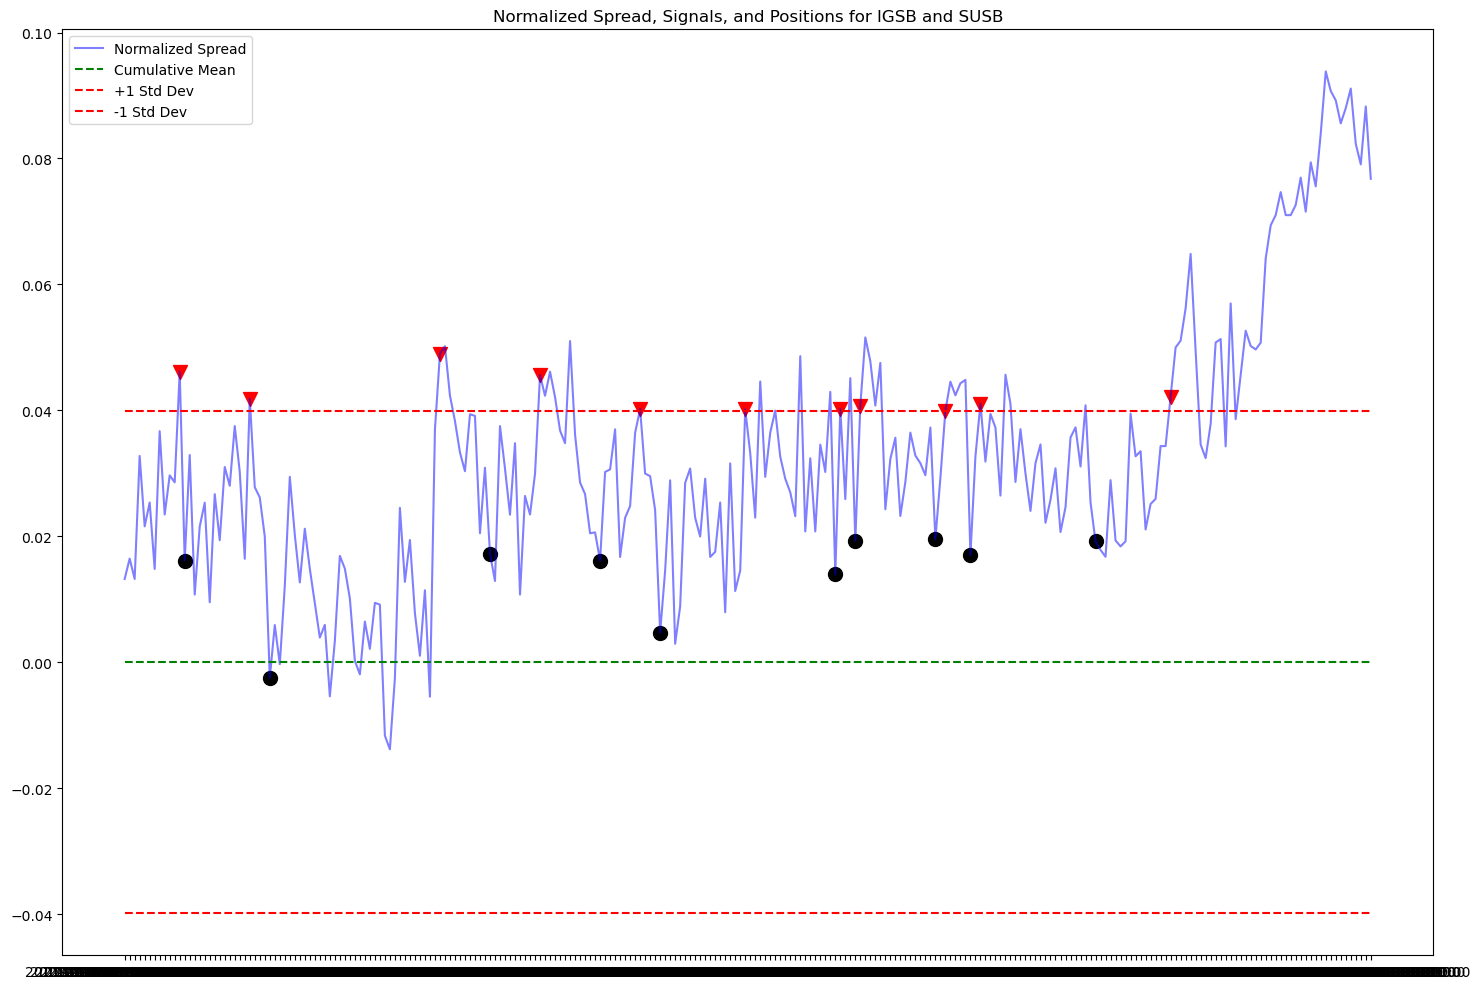

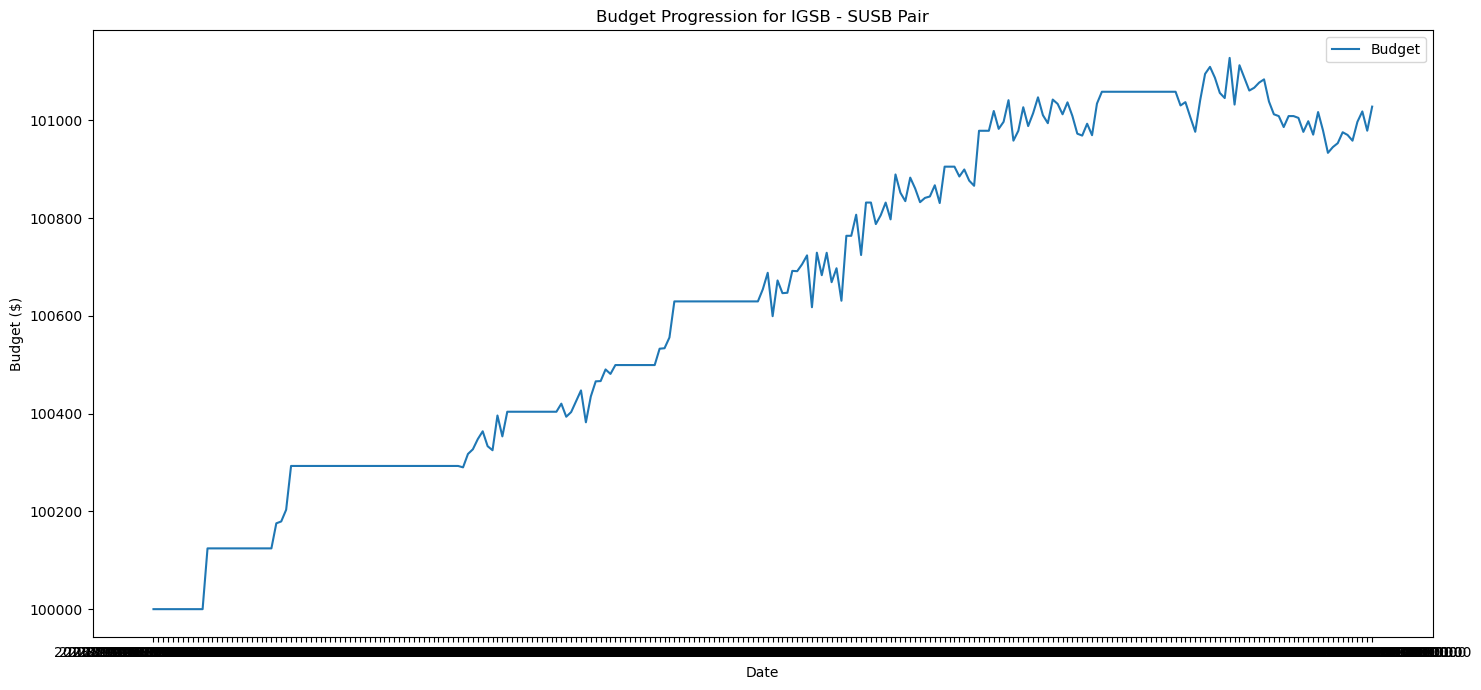

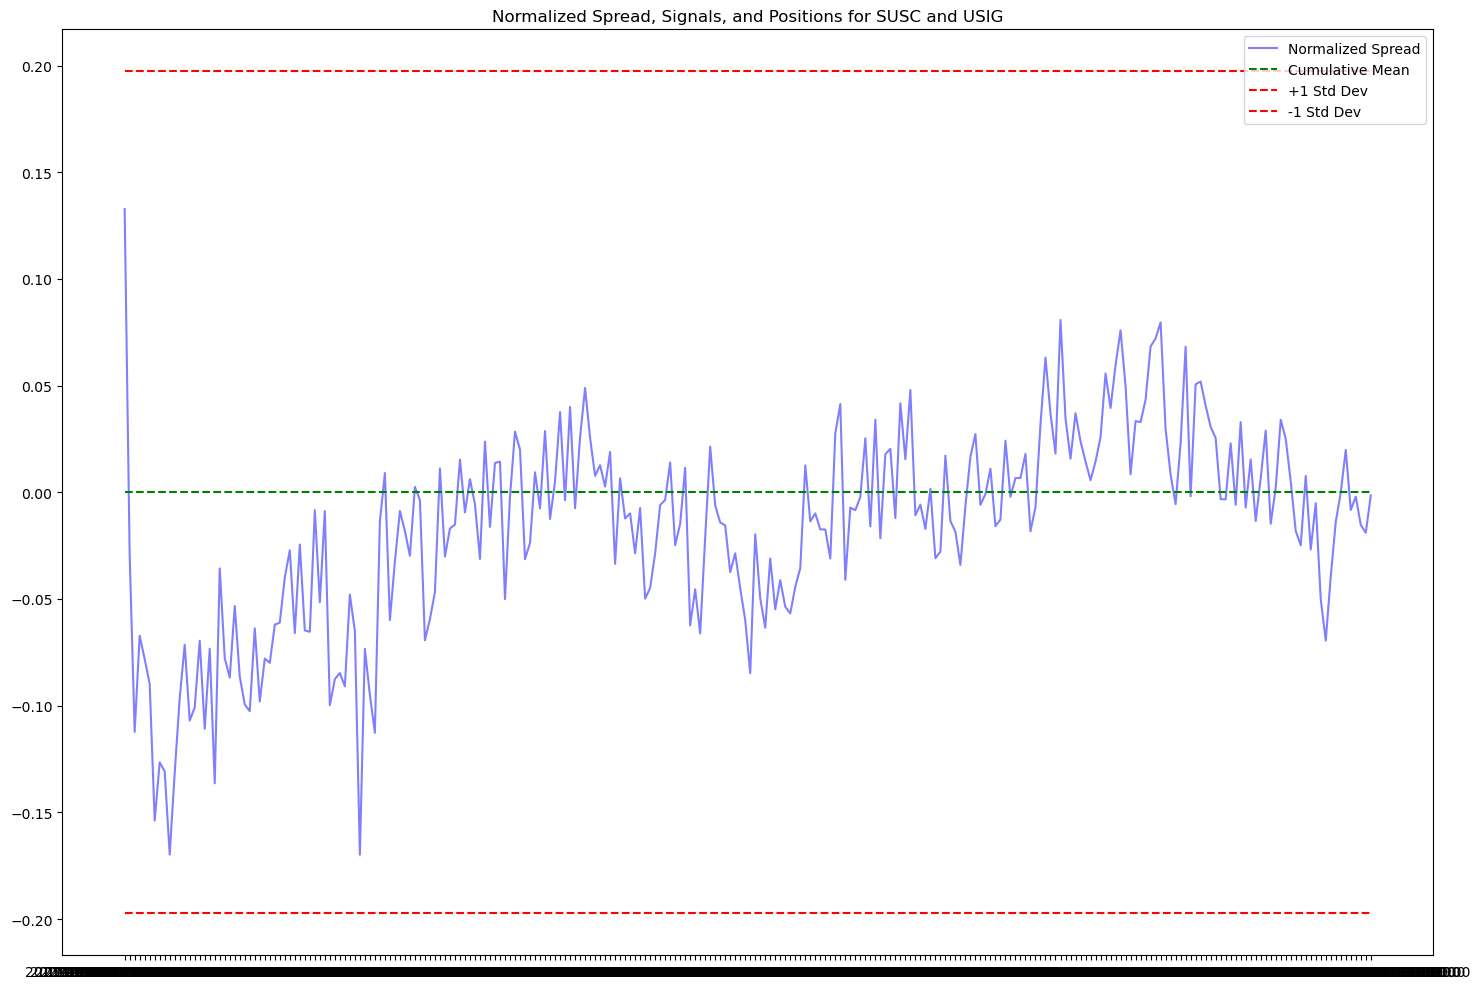

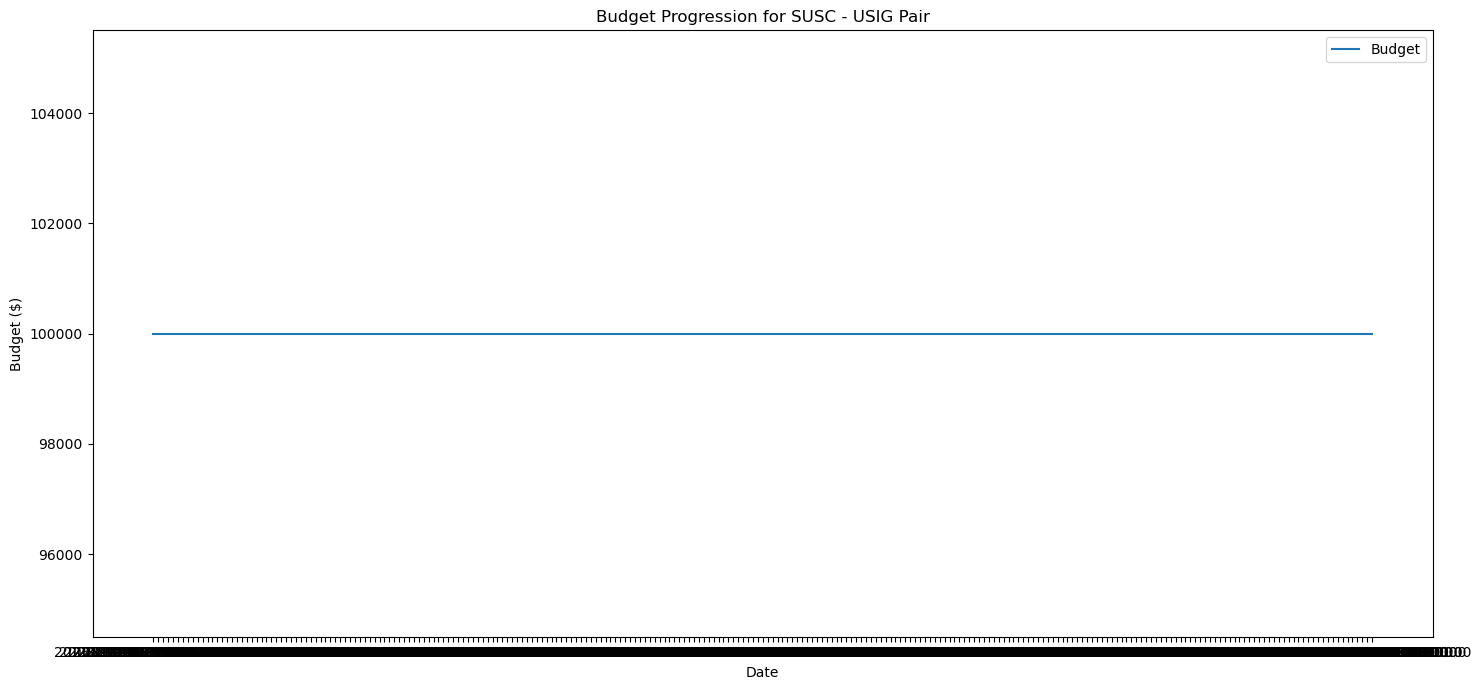

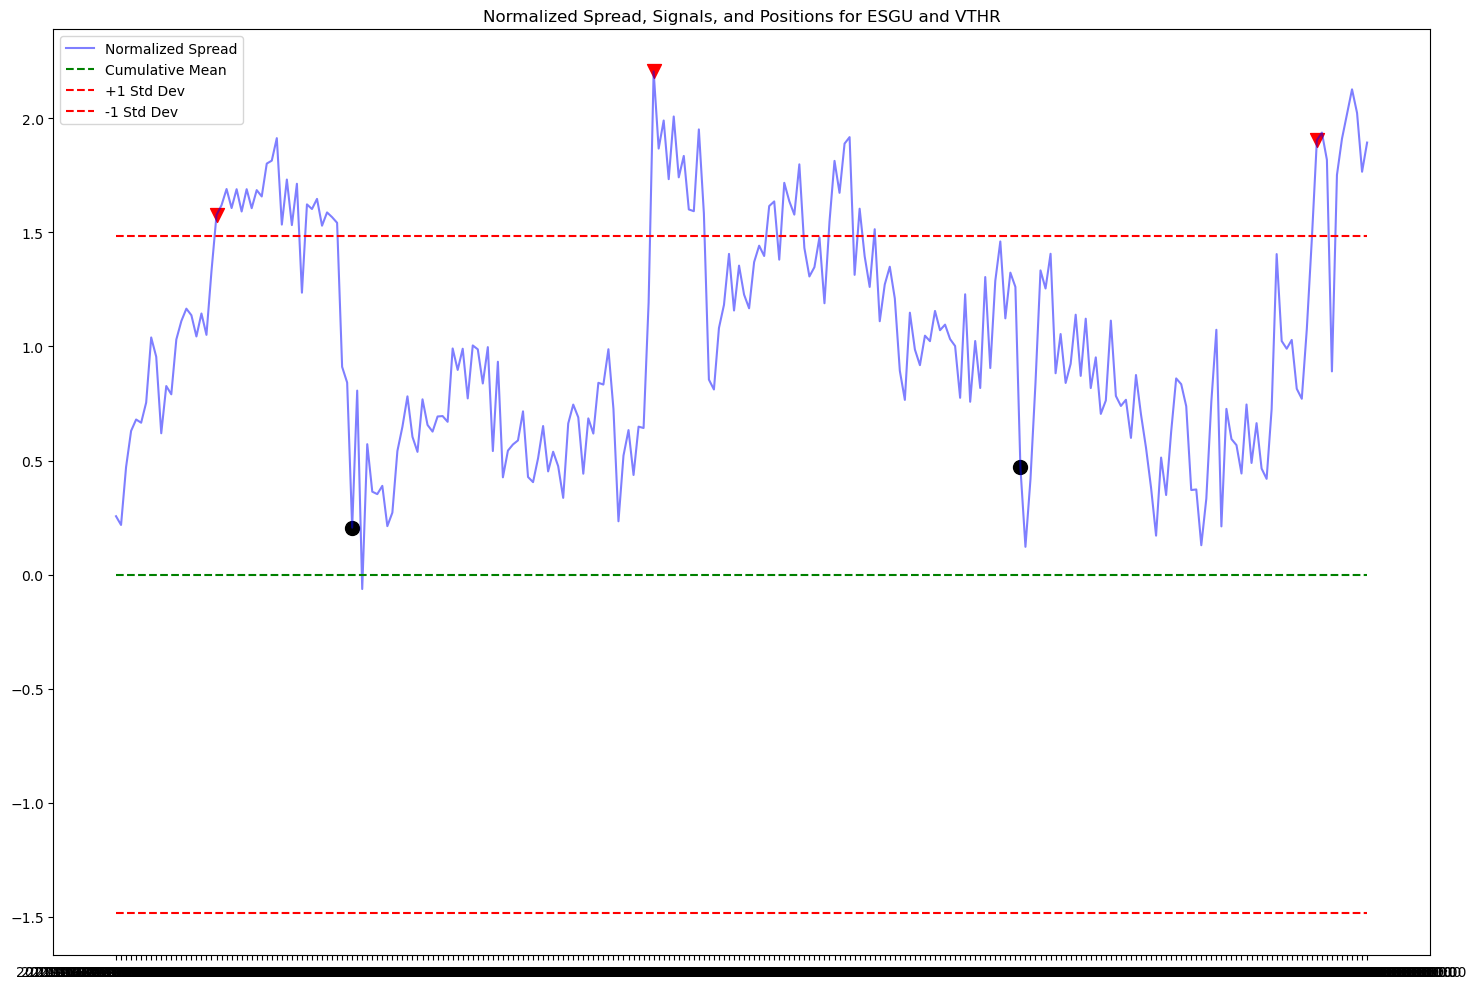

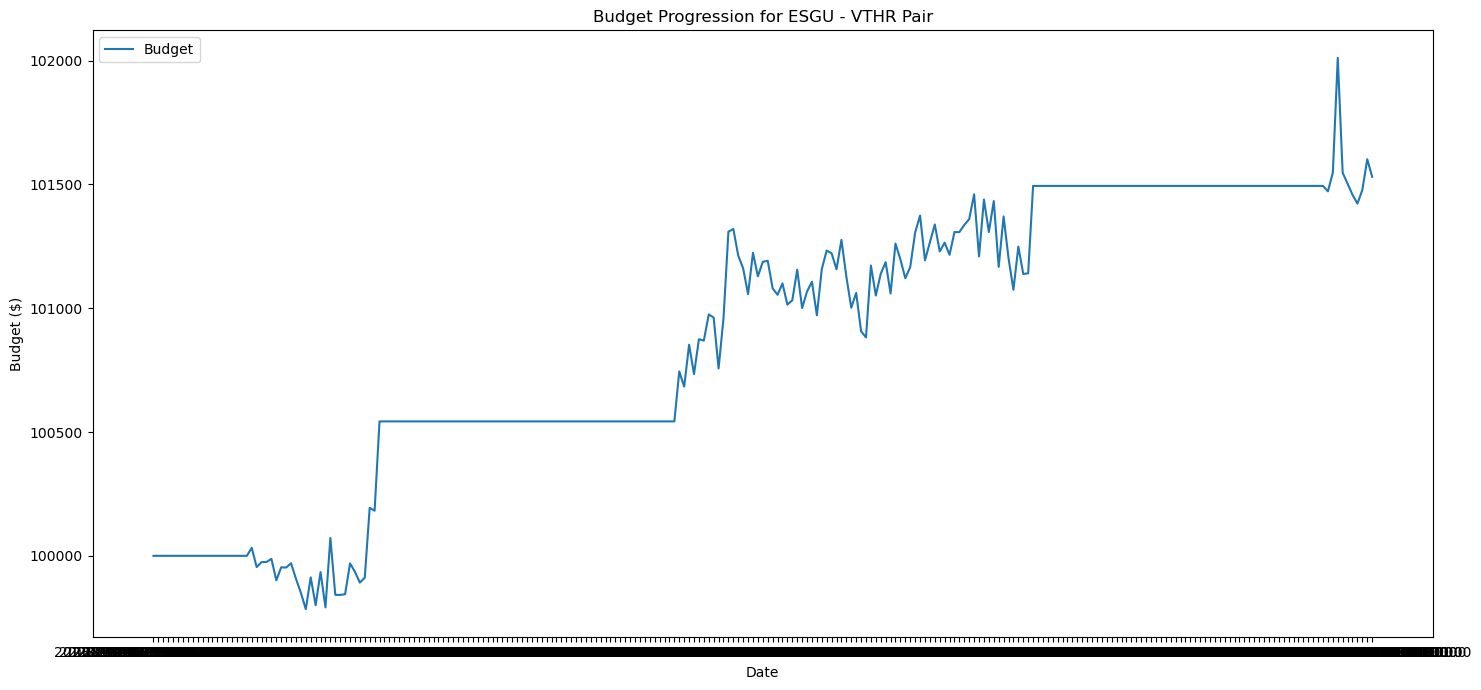

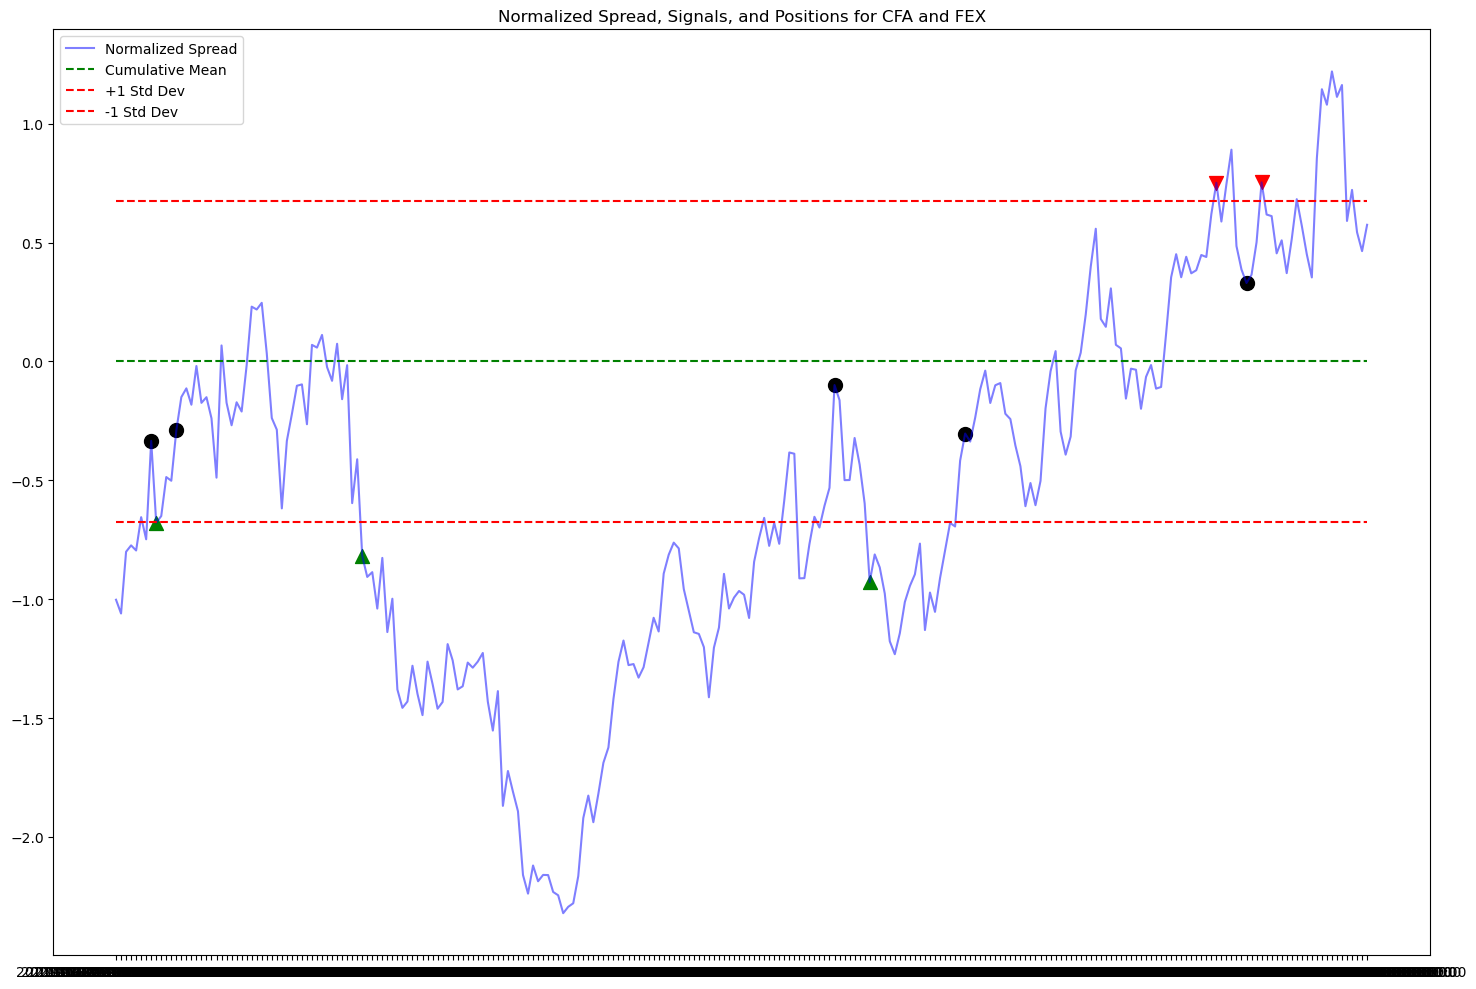

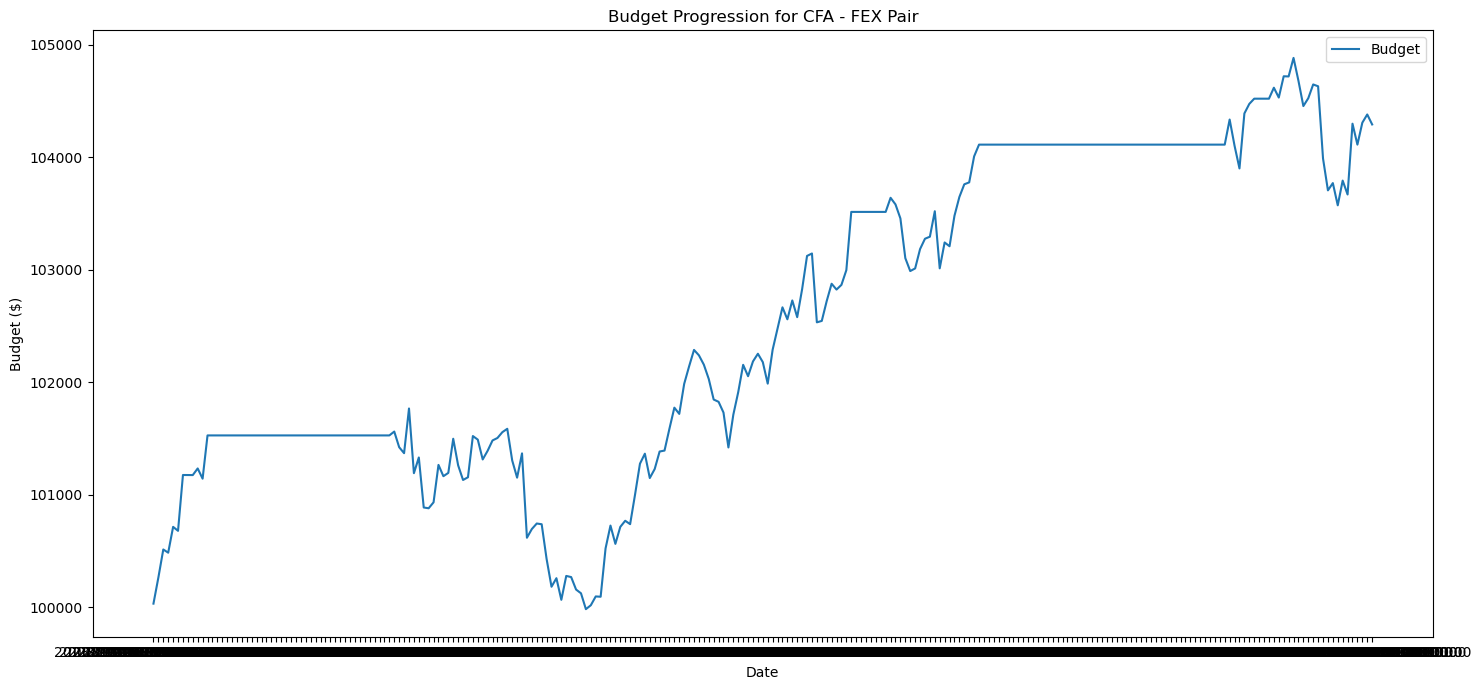

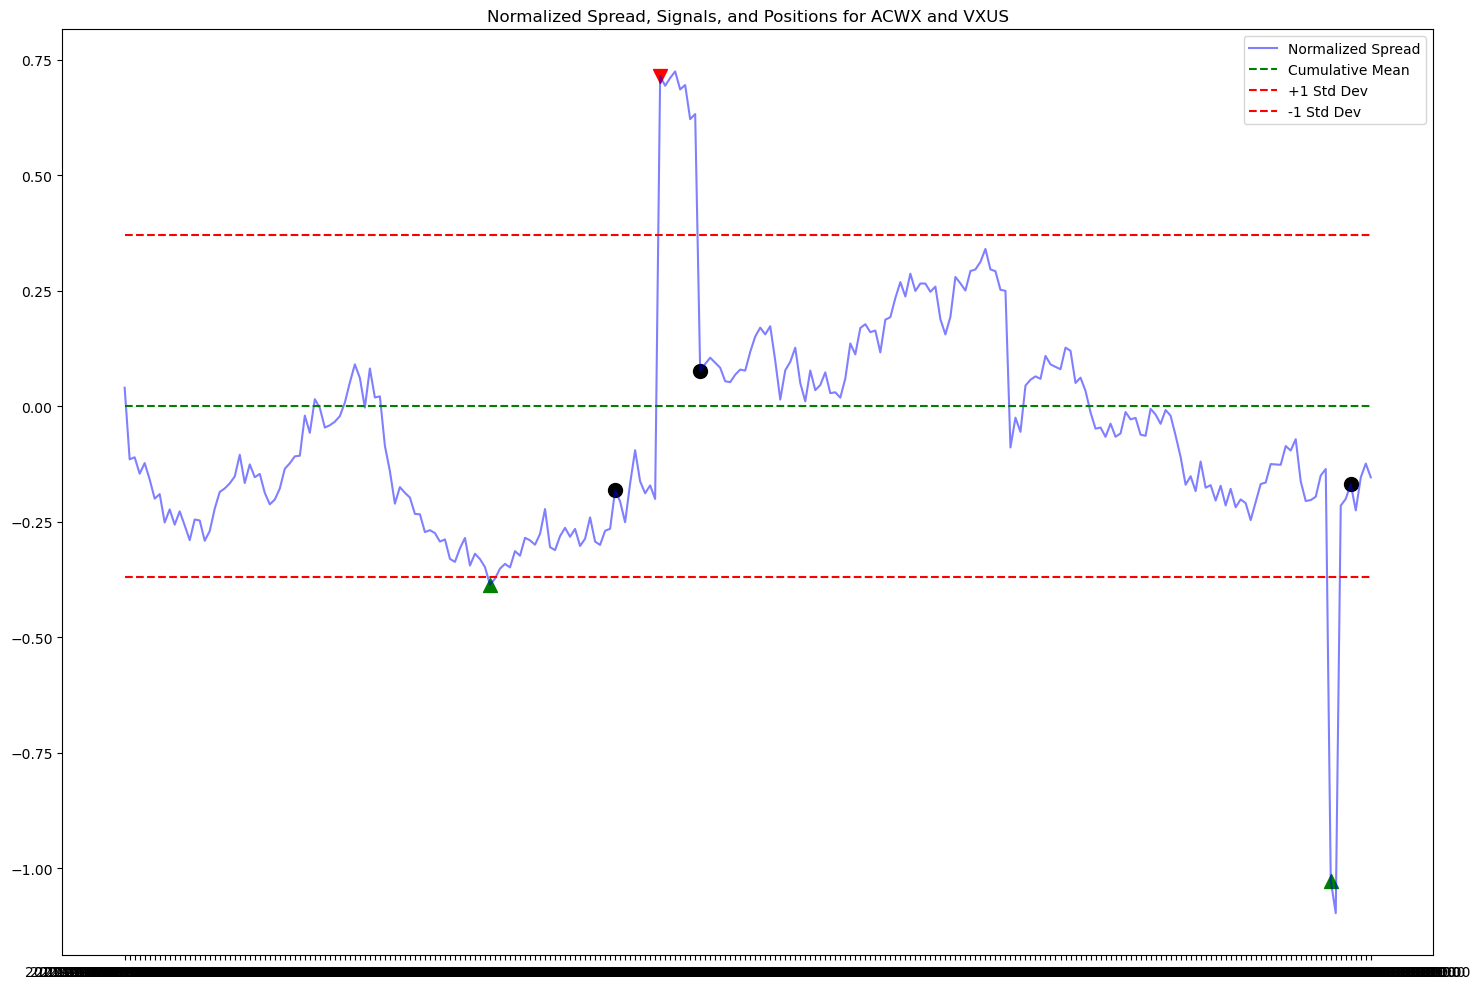

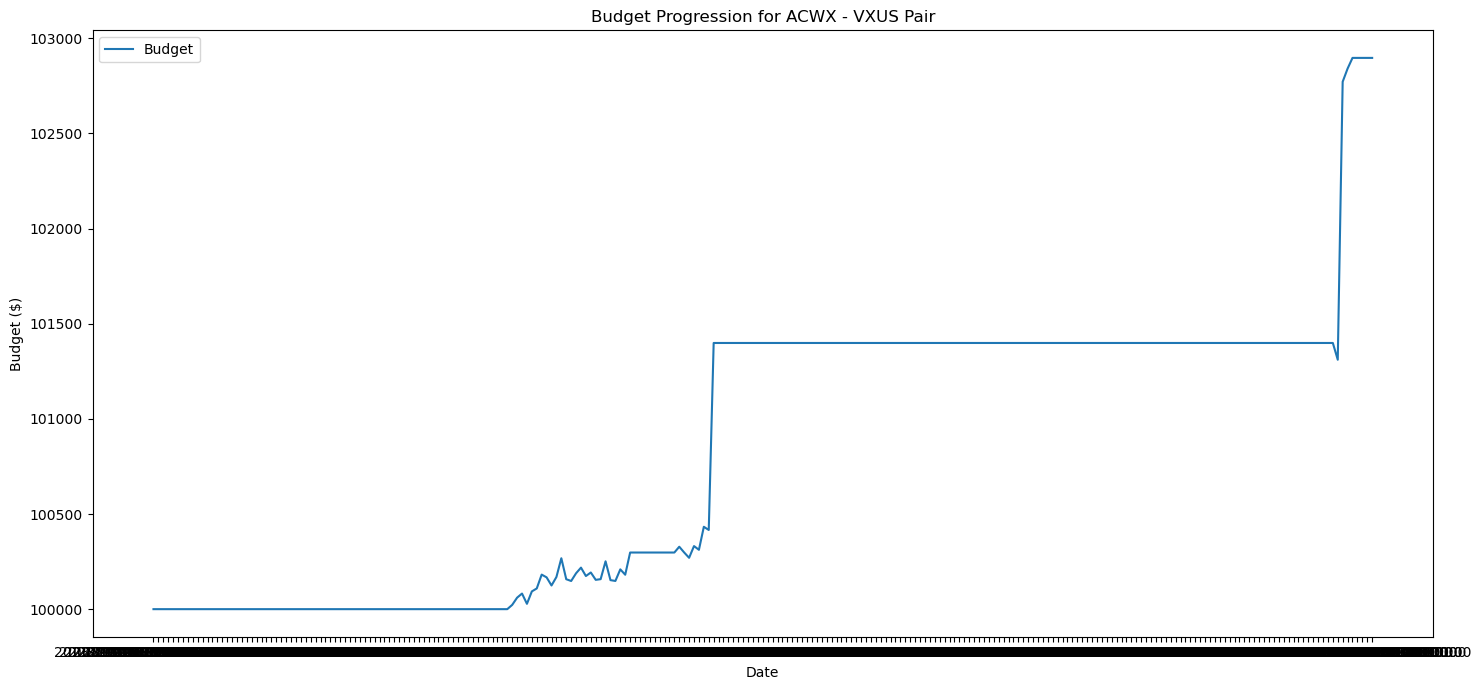

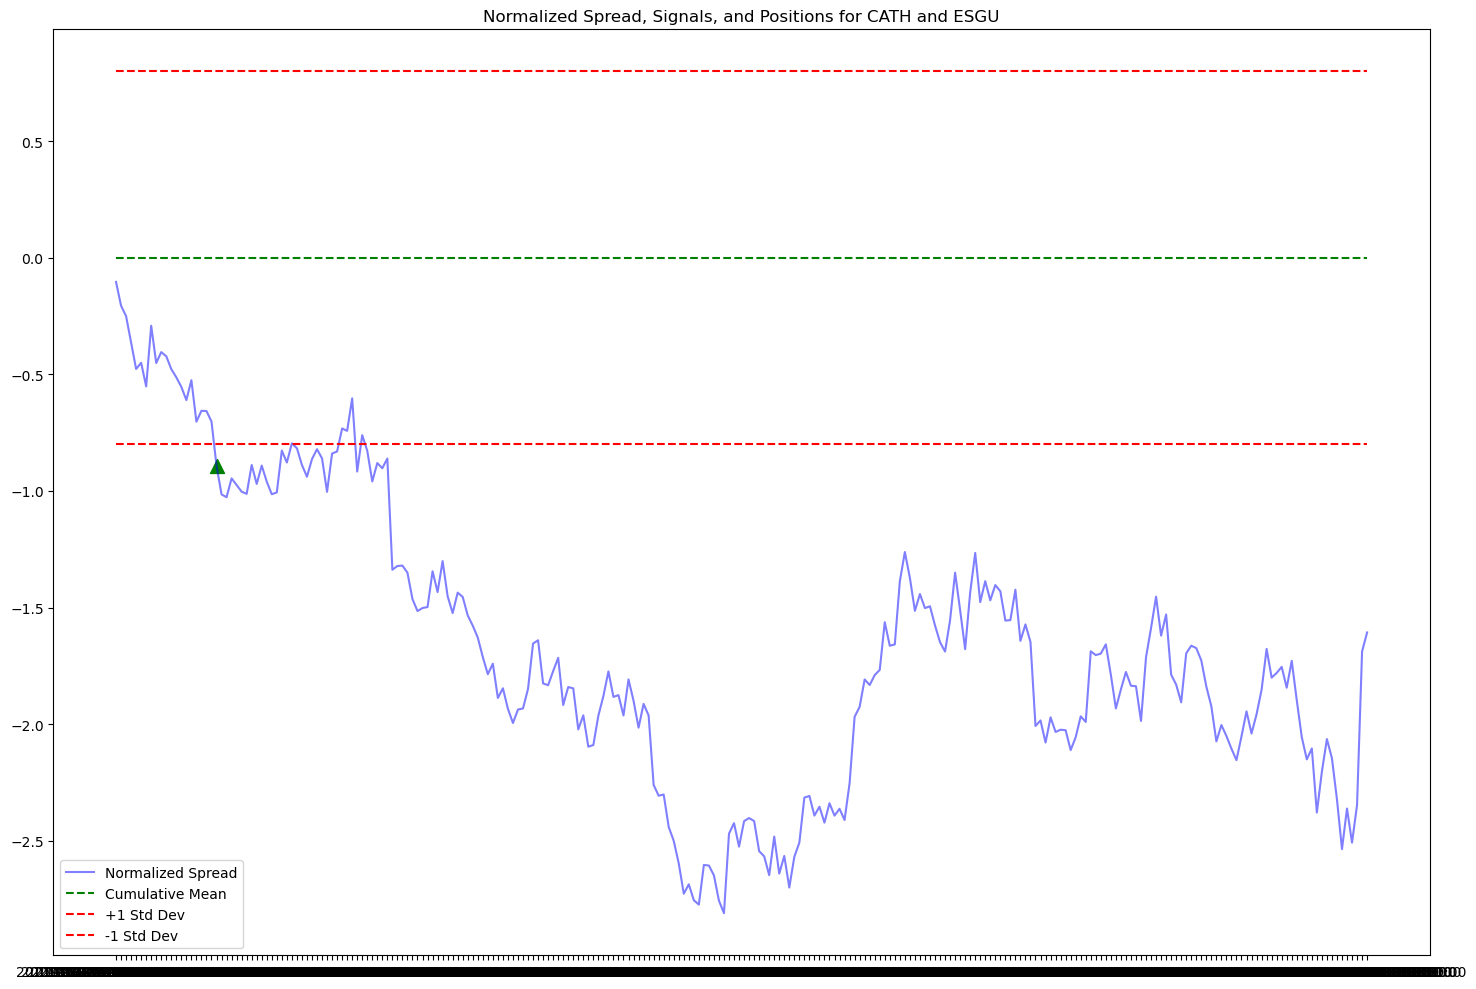

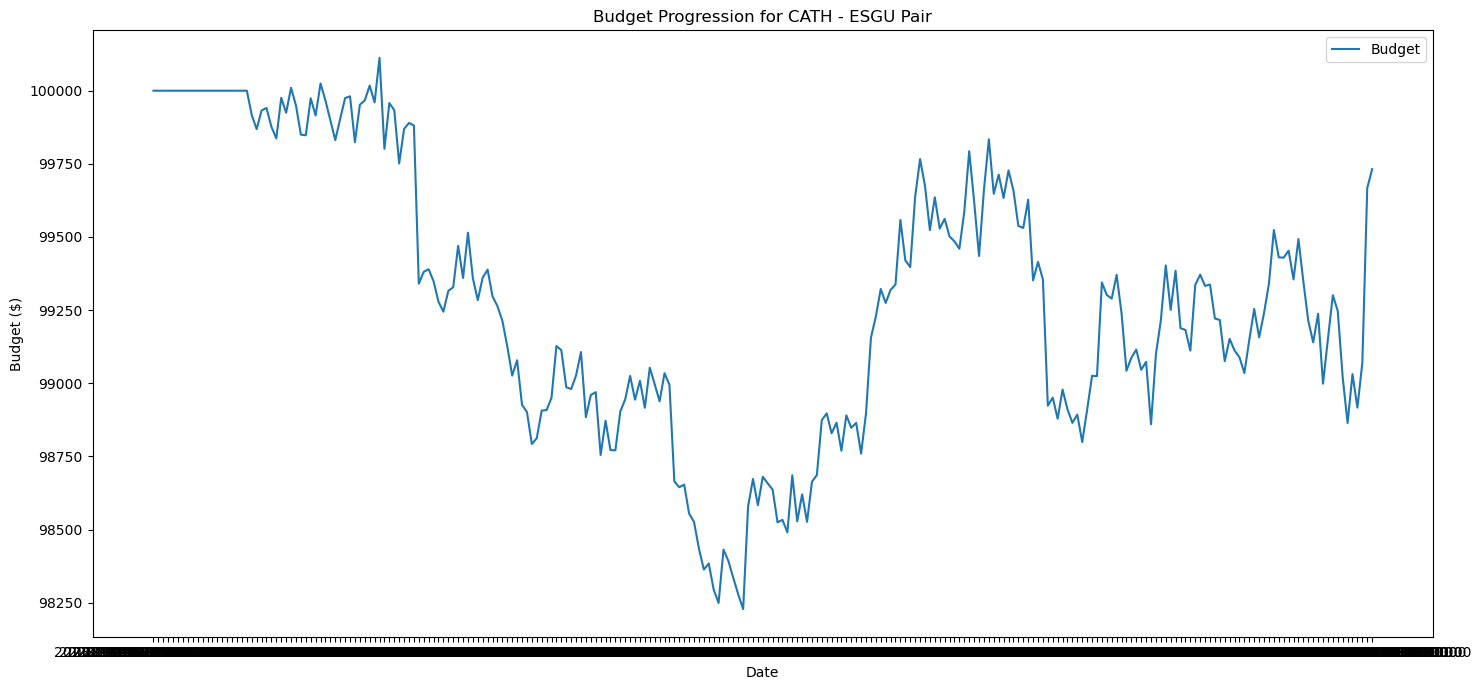

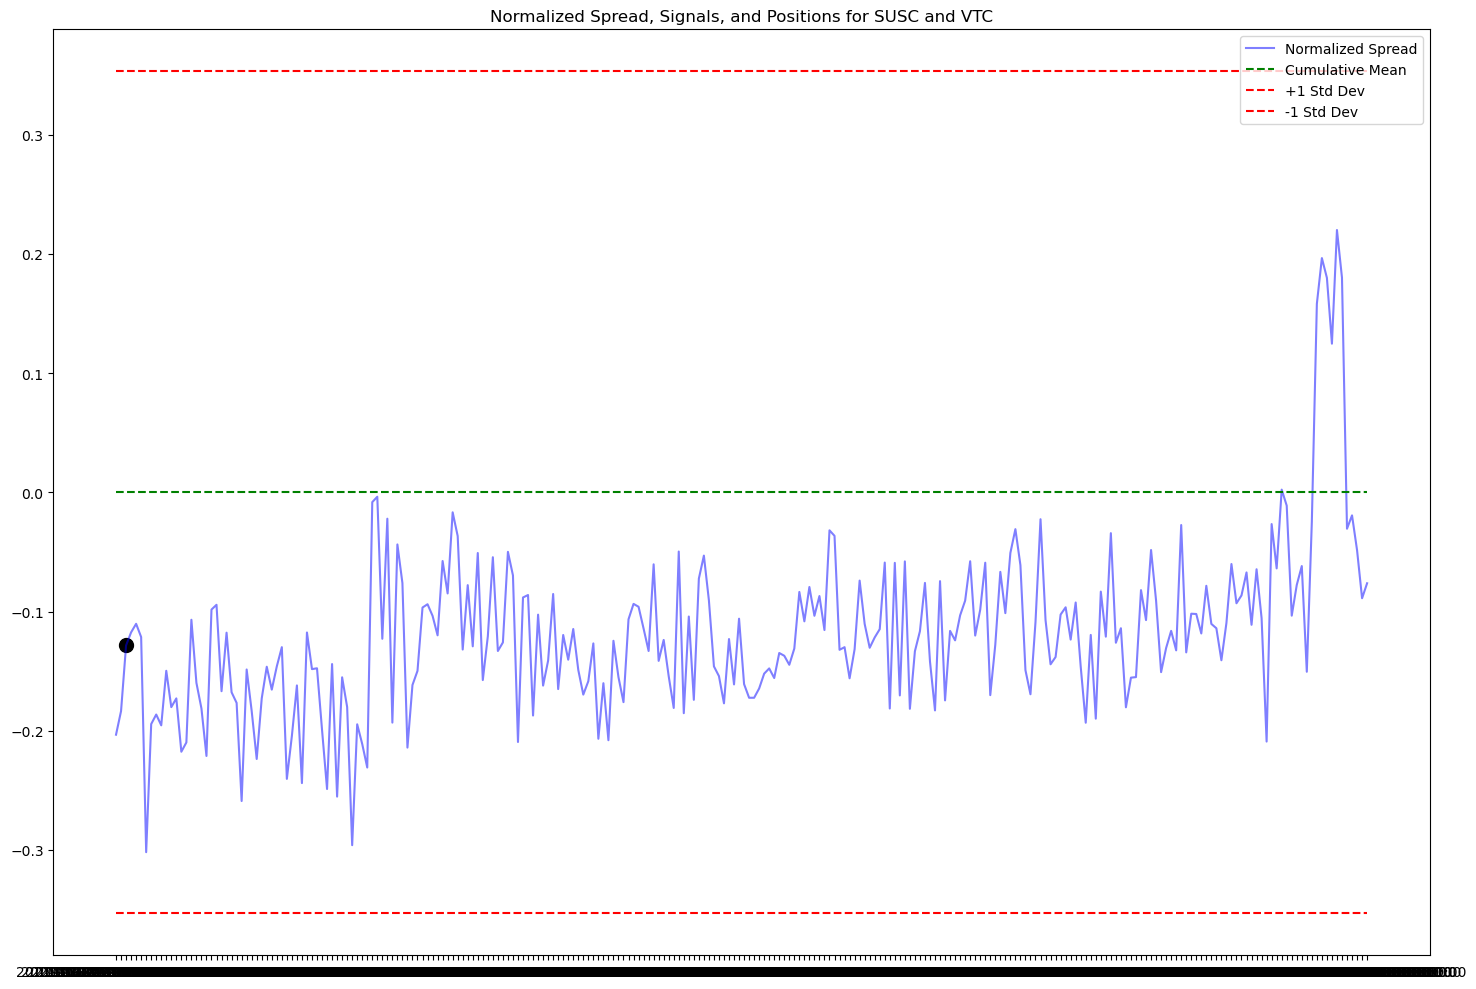

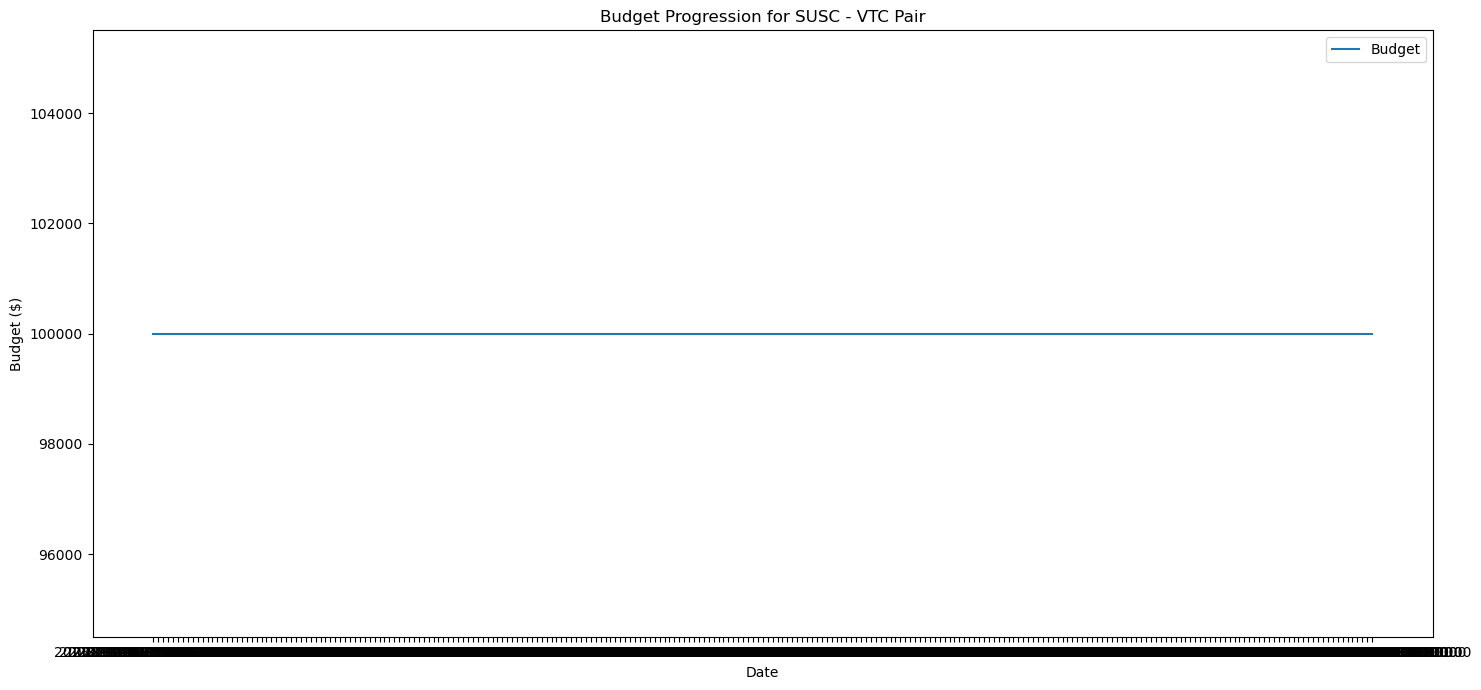

In [6]:
# Load data and loop through pairs to compute P&L

df = pd.read_csv("../../data/etf_prices_backtest.csv")
df.set_index("Timestamp", inplace=True)

nan_percentages = df.isna().mean()[1:] * 100

valid_etfs = nan_percentages[nan_percentages == 0]
df = df[valid_etfs.index]

valid_columns = df.columns[df.iloc[0].notna() & df.iloc[-1].notna()]
df = df[valid_columns]

df_returns = df.pct_change().iloc[1:]

dates = df.index

initial_budget = 100000
budget = [initial_budget]

results_list = []

for pair in top_19_pairs_list:
    ticker_1 = pair[0]
    ticker_2 = pair[1]

    ticker_series_1 = df[ticker_1]
    ticker_series_2 = df[ticker_2]

    spread = ticker_series_2 - (spread_stats[f"{ticker_1}_{ticker_2}"]["slope"] * ticker_series_1 + spread_stats[f"{ticker_1}_{ticker_2}"]["intercept"])

    upper_bound = spread_stats[f"{ticker_1}_{ticker_2}"]["mean"] + spread_stats[f"{ticker_1}_{ticker_2}"]["std"]
    lower_bound = spread_stats[f"{ticker_1}_{ticker_2}"]["mean"] - spread_stats[f"{ticker_1}_{ticker_2}"]["std"]

    positions = pd.Series(index=spread.index, dtype=int)

    positions[spread > upper_bound] = -1
    positions[spread < lower_bound] = 1
    positions[(spread >= (spread_stats[f"{ticker_1}_{ticker_2}"]["mean"] - spread_stats[f"{ticker_1}_{ticker_2}"]["std"]) * 0.5) & (spread <= (spread_stats[f"{ticker_1}_{ticker_2}"]["mean"] + spread_stats[f"{ticker_1}_{ticker_2}"]["std"])*0.5)] = 0

    positions = positions.ffill()

    spread_mean = spread_stats[f"{ticker_1}_{ticker_2}"]["mean"]
    spread_std = spread_stats[f"{ticker_1}_{ticker_2}"]["std"]

    spread_mean_series = pd.Series([spread_mean] * len(dates))
    spread_std_series = pd.Series([spread_std] * len(dates))

    if pd.isna(positions.iloc[0]):
        positions.iloc[0] = 0

    returns = []
    for i in range(1, len(positions)):
        if positions.iloc[i-1] == 1:
            return_1 = -(ticker_series_1.iloc[i] / ticker_series_1.iloc[i-1] - 1)
            return_2 = ticker_series_2.iloc[i] / ticker_series_2.iloc[i-1] - 1
            daily_return = return_1 + return_2
        elif positions.iloc[i-1] == -1:
            return_1 = ticker_series_1.iloc[i] / ticker_series_1.iloc[i-1] - 1
            return_2 = -(ticker_series_2.iloc[i] / ticker_series_2.iloc[i-1] - 1)
            daily_return = return_1 + return_2
        else:
            daily_return = 0
        
        returns.append(daily_return)
        budget.append(budget[-1] * (1 + daily_return))

    directory = f'../../assets/etfs/{ticker_1}_{ticker_2}'
    os.makedirs(directory, exist_ok=True)
    
    plt.figure(figsize=(15, 10))
    plt.plot(dates, spread.values, label='Normalized Spread', color='blue', alpha=0.5)
    plt.plot(dates, spread_mean_series, color='green', linestyle='--', label='Cumulative Mean')
    plt.plot(dates, spread_mean_series + spread_std_series, color='red', linestyle='--', label='+1 Std Dev')
    plt.plot(dates, spread_mean_series - spread_std_series, color='red', linestyle='--', label='-1 Std Dev')

    for i in range(1,len(positions)):
        if positions[i] != positions[i-1]:
            if positions[i] == 1:
                plt.scatter(dates[i], spread.values[i], color='green', marker='^', s=100)
            elif positions[i] == -1:
                plt.scatter(dates[i], spread.values[i], color='red', marker='v', s=100)
            elif positions[i] == 0:
                plt.scatter(dates[i], spread.values[i], color='black', marker='o', s=100)

    plt.title(f'Normalized Spread, Signals, and Positions for {ticker_1} and {ticker_2}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'../../assets/etfs/{ticker_1}_{ticker_2}/traditional_pairs_trading_positions_plot.png')

    plt.figure(figsize=(15, 7))
    plt.plot(df.index[1:], budget[1:], label='Budget')
    plt.title(f'Budget Progression for {ticker_1} - {ticker_2} Pair')
    plt.xlabel('Date')
    plt.ylabel('Budget ($)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'../../assets/etfs/{ticker_1}_{ticker_2}/traditional_pairs_trading_budget_progression.png')

    total_return = (budget[-1] - initial_budget) / initial_budget
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    sharpe_ratio = np.sqrt(252) * np.mean(returns) / np.std(returns)
    max_drawdown = np.min(np.array(budget) / np.maximum.accumulate(budget)) - 1

    pair_results = {
        "Name": f"{ticker_1} and {ticker_2}",
        "Total Return": total_return,
        "Annualized Return": annualized_return,
        "Sharpe Ratio": sharpe_ratio,
        "Maximum Drawdown": max_drawdown
    }

    results_list.append(pair_results)

    budget = [initial_budget]

results_df = pd.DataFrame(results_list)

results_df.to_csv('../../assets/etfs/backtesting_traditional_pairs_trading_results.csv', index=False)